In [1]:
# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')
print("✅ Google Drive 마운트가 완료되었습니다.")

Mounted at /content/drive
✅ Google Drive 마운트가 완료되었습니다.


In [2]:
# 필수 라이브러리 설치
!pip install tifffile imagecodecs rasterio

# 라이브러리 임포트
# 라이브러리 수정
import os
import glob
import numpy as np
import tifffile
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import rasterio

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

print("✅ 필요한 라이브러리 임포트가 완료되었습니다.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 114.7 MB/s eta 0:00:00
✅ 필요한 라이브러리 임포트가 완료되었습니다.


In [3]:
# 필수 라이브러리 설치
!pip install tifffile imagecodecs rasterio

# 라이브러리 임포트
# 라이브러리 수정
import os
import glob
import numpy as np
import tifffile
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import rasterio

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

print("✅ 필요한 라이브러리 임포트가 완료되었습니다.")

✅ 필요한 라이브러리 임포트가 완료되었습니다.


In [4]:
import pandas as pd

GDRIVE_BASE_PATH = "/content/drive/MyDrive/[EPOCH]/Brazilian E-Commerce Public Dataset"

customers = pd.read_csv("/content/drive/MyDrive/[EPOCH]/Brazilian E-Commerce Public Dataset/olist_customers_dataset.csv")
geolocation = pd.read_csv("/content/drive/MyDrive/[EPOCH]/Brazilian E-Commerce Public Dataset/olist_geolocation_dataset.csv")
order_items = pd.read_csv("/content/drive/MyDrive/[EPOCH]/Brazilian E-Commerce Public Dataset/olist_order_items_dataset.csv")
order_payments = pd.read_csv("/content/drive/MyDrive/[EPOCH]/Brazilian E-Commerce Public Dataset/olist_order_payments_dataset.csv")
order_reviews = pd.read_csv("/content/drive/MyDrive/[EPOCH]/Brazilian E-Commerce Public Dataset/olist_order_reviews_dataset.csv")
orders = pd.read_csv("/content/drive/MyDrive/[EPOCH]/Brazilian E-Commerce Public Dataset/olist_orders_dataset.csv")
products = pd.read_csv("/content/drive/MyDrive/[EPOCH]/Brazilian E-Commerce Public Dataset/olist_products_dataset.csv")
sellers = pd.read_csv("/content/drive/MyDrive/[EPOCH]/Brazilian E-Commerce Public Dataset/olist_sellers_dataset.csv")
category_name = pd.read_csv("/content/drive/MyDrive/[EPOCH]/Brazilian E-Commerce Public Dataset/product_category_name_translation.csv")

In [5]:
customers_geo = customers.rename(
    columns={"customer_zip_code_prefix": "geolocation_zip_code_prefix"}
)


In [6]:
df_train = orders.merge(order_items, on='order_id', how='left')
df_train = df_train.merge(order_payments, on='order_id', how='outer', validate='m:m')
df_train = df_train.merge(order_reviews, on='order_id', how='outer')
df_train = df_train.merge(products, on='product_id', how='outer')
df_train = df_train.merge(customers_geo, on='customer_id', how='outer')
df_train = df_train.merge(sellers, on='seller_id', how='outer')
df_train = df_train.merge(geolocation, on='geolocation_zip_code_prefix', how='outer')
df_train = df_train.merge(category_name, on='product_category_name', how='outer')

df_train

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,product_category_name_english
0,9dc960f739dffe11a498162d0d26c103,a21318b1cf4bb2e728275bb44c2829b5,delivered,2018-02-01 10:13:27,2018-02-03 02:53:59,2018-02-08 00:53:09,2018-02-09 22:16:37,2018-02-19 00:00:00,1.0,b5aebb467d9a92162173cbd234e00d99,...,sao paulo,SP,5528.0,sao paulo,SP,-23.522005,-46.633974,sao paulo,SP,agro_industry_and_commerce
1,9dc960f739dffe11a498162d0d26c103,a21318b1cf4bb2e728275bb44c2829b5,delivered,2018-02-01 10:13:27,2018-02-03 02:53:59,2018-02-08 00:53:09,2018-02-09 22:16:37,2018-02-19 00:00:00,1.0,b5aebb467d9a92162173cbd234e00d99,...,sao paulo,SP,5528.0,sao paulo,SP,-23.521656,-46.634423,são paulo,SP,agro_industry_and_commerce
2,9dc960f739dffe11a498162d0d26c103,a21318b1cf4bb2e728275bb44c2829b5,delivered,2018-02-01 10:13:27,2018-02-03 02:53:59,2018-02-08 00:53:09,2018-02-09 22:16:37,2018-02-19 00:00:00,1.0,b5aebb467d9a92162173cbd234e00d99,...,sao paulo,SP,5528.0,sao paulo,SP,-23.521656,-46.634423,sao paulo,SP,agro_industry_and_commerce
3,9dc960f739dffe11a498162d0d26c103,a21318b1cf4bb2e728275bb44c2829b5,delivered,2018-02-01 10:13:27,2018-02-03 02:53:59,2018-02-08 00:53:09,2018-02-09 22:16:37,2018-02-19 00:00:00,1.0,b5aebb467d9a92162173cbd234e00d99,...,sao paulo,SP,5528.0,sao paulo,SP,-23.522598,-46.633089,sao paulo,SP,agro_industry_and_commerce
4,9dc960f739dffe11a498162d0d26c103,a21318b1cf4bb2e728275bb44c2829b5,delivered,2018-02-01 10:13:27,2018-02-03 02:53:59,2018-02-08 00:53:09,2018-02-09 22:16:37,2018-02-19 00:00:00,1.0,b5aebb467d9a92162173cbd234e00d99,...,sao paulo,SP,5528.0,sao paulo,SP,-23.527881,-46.626873,são paulo,SP,agro_industry_and_commerce
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18220817,9c2e92a11614b3b94ef257a4eb8540d7,158af3ad0742719d373724b762396918,unavailable,2017-11-18 18:41:53,2017-11-18 18:55:27,NaN,NaN,2017-12-14 00:00:00,NaN,NaN,...,charrua,RS,NaN,NaN,NaN,-27.953409,-52.031394,charrua,RS,NaN
18220818,9c2e92a11614b3b94ef257a4eb8540d7,158af3ad0742719d373724b762396918,unavailable,2017-11-18 18:41:53,2017-11-18 18:55:27,NaN,NaN,2017-12-14 00:00:00,NaN,NaN,...,charrua,RS,NaN,NaN,NaN,-27.953858,-52.031943,charrua,RS,NaN
18220819,9c2e92a11614b3b94ef257a4eb8540d7,158af3ad0742719d373724b762396918,unavailable,2017-11-18 18:41:53,2017-11-18 18:55:27,NaN,NaN,2017-12-14 00:00:00,NaN,NaN,...,charrua,RS,NaN,NaN,NaN,-27.954114,-52.016483,charrua,RS,NaN
18220820,907057c26859398070400de963028855,f04c3f6e20a2a4318d97d7cec1d27bbf,shipped,2017-08-21 15:01:40,2017-08-21 15:15:10,2017-08-24 18:40:09,NaN,2017-09-21 00:00:00,1.0,e987172c2818cc16b2555bc130ac5fac,...,muliterno,RS,74550.0,goiania,GO,-28.329718,-51.769615,muliterno,RS,NaN


In [7]:
df_train.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'review_id', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'customer_unique_id', 'geolocation_zip_code_prefix', 'customer_city',
       'customer_state', 'seller_zip_code_prefix', 'seller_city',
       'seller_state', 'geolocation_lat', 'geolocation_lng',
       'geolocation_city', 'geolocation_state

In [9]:
pgina = pd.read_csv('/content/drive/MyDrive/[EPOCH]/Brazilian E-Commerce Public Dataset/State of Data 2021 - Dataset - Pgina1.csv')

pgina

,id,age,age_category,sex,live_spec,region,region_part,learn,major,emp_state,ind_sec,n_of_emp,manag_stat,role,current_role,salary_range,remote_work_flex,work_model
0,qkx4q0ei90wcjxnqkx4q0j3xgf0zn13s,38.0,35-39,Masculino,Cear? (CE),CE,Nordeste,P?s-gradua??o,Qu?mica / F?sica,Empregado (CLT),Marketing,de 101 a 500,1.0,Supervisor/Coordenador,NaN,de R$ 4.001/m?s a R$ 6.000/m?s,0.0,Modelo 100% presencial
1,zdl2n19yhgpnoaco6kkczdl2nwv9zwrt,39.0,35-39,Masculino,Bahia (BA),BA,Nordeste,P?s-gradua??o,Economia/ Administra??o / Contabilidade / Fina...,Empreendedor ou Empregado (CNPJ),Consultoria,de 1 a 5,1.0,"S?cio ou C-level (CEO, CDO, CIO, CTO etc)",NaN,de R$ 6.001/m?s a R$ 8.000/m?s,1.0,Modelo h?brido flex?vel (o funcion?rio tem lib...
2,vsamqp2un3q7us84mgvsams5fulsmcoh,30.0,30-34,Masculino,Santa Catarina (SC),SC,Sul,P?s-gradua??o,Computa??o / Engenharia de Software / Sistemas...,Empregado (CLT),Ind?stria,de 1001 a 3000,1.0,Supervisor/Coordenador,NaN,de R$ 8.001/m?s a R$ 12.000/m?s,0.0,Modelo 100% presencial
3,v31ab41botodnsv31zgg4k34zzojy81l,38.0,35-39,Feminino,S?o Paulo (SP),SP,Sudeste,P?s-gradua??o,Outras,Empreendedor ou Empregado (CNPJ),Servi?os,de 1001 a 3000,1.0,Gerente/Head/Diretor/VP,NaN,de R$ 12.001/m?s a R$ 16.000/m?s,1.0,Modelo 100% presencial
4,ubhu8ntvm4xc0sfkdubhu80e973eek0k,36.0,35-39,Masculino,Santa Catarina (SC),SC,Sul,P?s-gradua??o,Outras Engenharias,Empreendedor ou Empregado (CNPJ),Varejo,de 6 a 10,1.0,Gerente/Head/Diretor/VP,NaN,de R$ 8.001/m?s a R$ 12.000/m?s,0.0,Modelo 100% presencial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2640,07nvo8cdy377a46gon207nvjebwe65zg,40.0,40-44,Masculino,S?o Paulo (SP),SP,Sudeste,N?o tenho gradua??o formal,NaN,Trabalho na ?rea Acad?mica/Pesquisador,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2641,01mqnby32u01pg3nuj6vipp4mc06s8pg,27.0,25-29,Masculino,Santa Catarina (SC),SC,Sul,Gradua??o/Bacharelado,Estat?stica/ Matem?tica / Matem?tica Computaci...,Empregado (CLT),Tecnologia/F?brica de Software,de 501 a 1000,0.0,NaN,Cientista de Dados/Data Scientist,de R$ 6.001/m?s a R$ 8.000/m?s,0.0,Modelo 100% presencial
2642,01fncs8qbhl9zx01fncs8rqib2zl3d18,24.0,22-24,Masculino,Santa Catarina (SC),SC,Sul,Gradua??o/Bacharelado,Computa??o / Engenharia de Software / Sistemas...,Empregado (CLT),Tecnologia/F?brica de Software,Acima de 3000,0.0,NaN,Engenheiro de Dados/Data Engineer,de R$ 6.001/m?s a R$ 8.000/m?s,0.0,Modelo 100% remoto
2643,075h3v2z19if04yn7o075h3vhifl38rw,38.0,35-39,Masculino,Rio de Janeiro (RJ),RJ,Sudeste,Gradua??o/Bacharelado,Computa??o / Engenharia de Software / Sistemas...,"Desempregado, buscando recoloca??o",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
pgina.columns

Index(['id', 'age', 'age_category', 'sex', 'live_spec', 'region',
       'region_part', 'learn', 'major', 'emp_state', 'ind_sec', 'n_of_emp',
       'manag_stat', 'role', 'current_role', 'salary_range',
       'remote_work_flex', 'work_model'],
      dtype='object')

In [15]:
import re
import numpy as np
import pandas as pd

# -----------------------------------
# Config
# -----------------------------------
FILE_PATH = '/content/drive/MyDrive/[EPOCH]/Brazilian E-Commerce Public Dataset/State of Data 2021 - Dataset - Pgina1.csv' # 수정 가능
OUTPUT_PATH = '/content/drive/MyDrive/[EPOCH]/Brazilian E-Commerce Public Dataset/processed_data.csv'         # 수정 가능
SAL_COL = "salary_range"                                           # 원본 컬럼명

# -----------------------------------
def _ptbr_num_to_float(s: str) -> float:
    """'40.001' -> 40001.0, '1.500,75' -> 1500.75"""
    s = s.replace(".", "").replace(",", ".")
    try:
        return float(s)
    except Exception:
        return np.nan

def parse_salary_range(text: str):
    """
    text 예시:
      - 'de R$ 4.001/mês a R$ 6.000/mês'
      - 'Menos de R$ 1.000/mês'
      - 'Acima de R$ 40.001/mês'
      - 인코딩 변형: 'm?s' 등은 무시
    return: (min_val, max_val, mid_val)
    """
    if not isinstance(text, str) or not text.strip():
        return (np.nan, np.nan, np.nan)

    # 인코딩 변형 단어 제거 (mês/m?s 등 월 표기, 공백 정리)
    t = re.sub(r"m[\S]*", "", text, flags=re.IGNORECASE)  # 'mês', 'm?s' 등 제거
    t = re.sub(r"\s+", " ", t).strip()

    # 범위: de R$ X a R$ Y
    m_range = re.search(r"de\s*R\$\s*([\d\.,]+)\s*a\s*R\$\s*([\d\.,]+)", t, flags=re.IGNORECASE)
    if m_range:
        lo = _ptbr_num_to_float(m_range.group(1))
        hi = _ptbr_num_to_float(m_range.group(2))
        mid = np.nanmean([lo, hi])
        return (lo, hi, mid)

    # 상한만 있는 경우: Menos de R$ X
    m_less = re.search(r"Menos\s+de\s*R\$\s*([\d\.,]+)", t, flags=re.IGNORECASE)
    if m_less:
        hi = _ptbr_num_to_float(m_less.group(1))
        lo = 0.0
        mid = np.nanmean([lo, hi])
        return (lo, hi, mid)

    # 하한만 있는 경우: Acima de R$ X
    m_above = re.search(r"Acima\s+de\s*R\$\s*([\d\.,]+)", t, flags=re.IGNORECASE)
    if m_above:
        lo = _ptbr_num_to_float(m_above.group(1))
        hi = np.nan  # 상한 불명
        mid = lo     # 보수적으로 하한 사용
        return (lo, hi, mid)

    # 숫자 하나만 있는 경우 대비 (fallback)
    m_one = re.search(r"R\$\s*([\d\.,]+)", t, flags=re.IGNORECASE)
    if m_one:
        v = _ptbr_num_to_float(m_one.group(1))
        return (v, v, v)

    return (np.nan, np.nan, np.nan)

def assign_income_class(mid_val: float) -> str:
    """
    임의 클래스 기준 (월소득, BRL):
        E: ≤ 2k
        D: 2k ~ 4k
        C: 4k ~ 10k
        B: 10k ~ 20k
        A: > 20k
    """
    if pd.isna(mid_val):
        return np.nan
    if mid_val <= 2000:
        return "E (≤2k)"
    if mid_val <= 4000:
        return "D (2k–4k)"
    if mid_val <= 10000:
        return "C (4k–10k)"
    if mid_val <= 20000:
        return "B (10k–20k)"
    return "A (>20k)"

# -----------------------------------
# Load
# -----------------------------------
df = pd.read_csv(FILE_PATH)

# -----------------------------------
# Transform
# -----------------------------------
sal_parsed = df[SAL_COL].apply(parse_salary_range)
df["salary_min_brl"] = sal_parsed.apply(lambda x: x[0])
df["salary_max_brl"] = sal_parsed.apply(lambda x: x[1])
df["salary_mid_brl"] = sal_parsed.apply(lambda x: x[2])

df["income_class"] = df["salary_mid_brl"].apply(assign_income_class)

# (선택) 범주 순서 지정
cat_order = ["E (≤2k)", "D (2k–4k)", "C (4k–10k)", "B (10k–20k)", "A (>20k)"]
df["income_class"] = pd.Categorical(df["income_class"], categories=cat_order, ordered=True)

# -----------------------------------
# Save
# -----------------------------------
df.to_csv(OUTPUT_PATH, index=False)
print("Saved:", OUTPUT_PATH)

# (선택) 결과 요약 확인
print(df[["salary_range", "salary_min_brl", "salary_max_brl", "salary_mid_brl", "income_class"]].head(12))

Saved: /content/drive/MyDrive/[EPOCH]/Brazilian E-Commerce Public Dataset/processed_data.csv
                        salary_range  salary_min_brl  salary_max_brl  \
0     de R$ 4.001/m?s a R$ 6.000/m?s          4001.0          4001.0   
1     de R$ 6.001/m?s a R$ 8.000/m?s          6001.0          6001.0   
2    de R$ 8.001/m?s a R$ 12.000/m?s          8001.0          8001.0   
3   de R$ 12.001/m?s a R$ 16.000/m?s         12001.0         12001.0   
4    de R$ 8.001/m?s a R$ 12.000/m?s          8001.0          8001.0   
5    de R$ 8.001/m?s a R$ 12.000/m?s          8001.0          8001.0   
6     de R$ 3.001/m?s a R$ 4.000/m?s          3001.0          3001.0   
7   de R$ 12.001/m?s a R$ 16.000/m?s         12001.0         12001.0   
8     de R$ 4.001/m?s a R$ 6.000/m?s          4001.0          4001.0   
9     de R$ 4.001/m?s a R$ 6.000/m?s          4001.0          4001.0   
10  de R$ 30.001/m?s a R$ 40.000/m?s         30001.0         30001.0   
11    de R$ 6.001/m?s a R$ 8.000/m?s       

In [18]:
import re
import numpy as np
import pandas as pd

def _ptbr_num_to_float(s: str) -> float:
    s = s.replace(".", "").replace(",", ".")
    try:
        return float(s)
    except Exception:
        return np.nan

def parse_salary_range(text: str):
    """
    text 예시:
      - 'de R$ 4.001/mês a R$ 6.000/mês'
      - 'Menos de R$ 1.000/mês'
      - 'Acima de R$ 40.001/mês'
      - 인코딩 변형: 'm?s' 등
    return: (min_val, max_val, mid_val)
    """
    if not isinstance(text, str) or not text.strip():
        return (np.nan, np.nan, np.nan)

    t = text.strip()

    # 1) '/mês', '/m?s' 같은 월 표기만 제거 (문장 나머지는 그대로 유지)
    t = re.sub(r"/m(?:ê|e|\?)s", "", t, flags=re.IGNORECASE)

    # 2) 공백 정리
    t = re.sub(r"\s+", " ", t).strip()

    # 3) 범위: de R$ X a R$ Y
    m_range = re.search(r"de\s*R\$\s*([\d\.,]+)\s*a\s*R\$\s*([\d\.,]+)", t, flags=re.IGNORECASE)
    if m_range:
        lo = _ptbr_num_to_float(m_range.group(1))
        hi = _ptbr_num_to_float(m_range.group(2))
        mid = np.nanmean([lo, hi])
        return (lo, hi, mid)

    # 4) 상한만: Menos de R$ X
    m_less = re.search(r"Menos\s+de\s*R\$\s*([\d\.,]+)", t, flags=re.IGNORECASE)
    if m_less:
        hi = _ptbr_num_to_float(m_less.group(1))
        lo = 0.0
        mid = np.nanmean([lo, hi])
        return (lo, hi, mid)

    # 5) 하한만: Acima de R$ X
    m_above = re.search(r"Acima\s+de\s*R\$\s*([\d\.,]+)", t, flags=re.IGNORECASE)
    if m_above:
        lo = _ptbr_num_to_float(m_above.group(1))
        hi = np.nan
        mid = lo
        return (lo, hi, mid)

    # 6) 숫자 하나만 있는 경우
    m_one = re.search(r"R\$\s*([\d\.,]+)", t, flags=re.IGNORECASE)
    if m_one:
        v = _ptbr_num_to_float(m_one.group(1))
        return (v, v, v)

    return (np.nan, np.nan, np.nan)

# ----- 적용 예시 -----
# df = pd.read_csv("/mnt/data/State of Data 2021 - Dataset - Pgina1.csv")
sal_parsed = df["salary_range"].apply(parse_salary_range)
df["salary_min_brl"] = sal_parsed.apply(lambda x: x[0])
df["salary_max_brl"] = sal_parsed.apply(lambda x: x[1])
df["salary_mid_brl"] = sal_parsed.apply(lambda x: x[2])


In [19]:
df

,id,age,age_category,sex,live_spec,region,region_part,learn,major,emp_state,...,manag_stat,role,current_role,salary_range,remote_work_flex,work_model,salary_min_brl,salary_max_brl,salary_mid_brl,income_class
0,qkx4q0ei90wcjxnqkx4q0j3xgf0zn13s,38.0,35-39,Masculino,Cear? (CE),CE,Nordeste,P?s-gradua??o,Qu?mica / F?sica,Empregado (CLT),...,1.0,Supervisor/Coordenador,NaN,de R$ 4.001/m?s a R$ 6.000/m?s,0.0,Modelo 100% presencial,4001.0,6000.0,5000.5,C (4k–10k)
1,zdl2n19yhgpnoaco6kkczdl2nwv9zwrt,39.0,35-39,Masculino,Bahia (BA),BA,Nordeste,P?s-gradua??o,Economia/ Administra??o / Contabilidade / Fina...,Empreendedor ou Empregado (CNPJ),...,1.0,"S?cio ou C-level (CEO, CDO, CIO, CTO etc)",NaN,de R$ 6.001/m?s a R$ 8.000/m?s,1.0,Modelo h?brido flex?vel (o funcion?rio tem lib...,6001.0,8000.0,7000.5,C (4k–10k)
2,vsamqp2un3q7us84mgvsams5fulsmcoh,30.0,30-34,Masculino,Santa Catarina (SC),SC,Sul,P?s-gradua??o,Computa??o / Engenharia de Software / Sistemas...,Empregado (CLT),...,1.0,Supervisor/Coordenador,NaN,de R$ 8.001/m?s a R$ 12.000/m?s,0.0,Modelo 100% presencial,8001.0,12000.0,10000.5,C (4k–10k)
3,v31ab41botodnsv31zgg4k34zzojy81l,38.0,35-39,Feminino,S?o Paulo (SP),SP,Sudeste,P?s-gradua??o,Outras,Empreendedor ou Empregado (CNPJ),...,1.0,Gerente/Head/Diretor/VP,NaN,de R$ 12.001/m?s a R$ 16.000/m?s,1.0,Modelo 100% presencial,12001.0,16000.0,14000.5,B (10k–20k)
4,ubhu8ntvm4xc0sfkdubhu80e973eek0k,36.0,35-39,Masculino,Santa Catarina (SC),SC,Sul,P?s-gradua??o,Outras Engenharias,Empreendedor ou Empregado (CNPJ),...,1.0,Gerente/Head/Diretor/VP,NaN,de R$ 8.001/m?s a R$ 12.000/m?s,0.0,Modelo 100% presencial,8001.0,12000.0,10000.5,C (4k–10k)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2640,07nvo8cdy377a46gon207nvjebwe65zg,40.0,40-44,Masculino,S?o Paulo (SP),SP,Sudeste,N?o tenho gradua??o formal,NaN,Trabalho na ?rea Acad?mica/Pesquisador,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2641,01mqnby32u01pg3nuj6vipp4mc06s8pg,27.0,25-29,Masculino,Santa Catarina (SC),SC,Sul,Gradua??o/Bacharelado,Estat?stica/ Matem?tica / Matem?tica Computaci...,Empregado (CLT),...,0.0,NaN,Cientista de Dados/Data Scientist,de R$ 6.001/m?s a R$ 8.000/m?s,0.0,Modelo 100% presencial,6001.0,8000.0,7000.5,C (4k–10k)
2642,01fncs8qbhl9zx01fncs8rqib2zl3d18,24.0,22-24,Masculino,Santa Catarina (SC),SC,Sul,Gradua??o/Bacharelado,Computa??o / Engenharia de Software / Sistemas...,Empregado (CLT),...,0.0,NaN,Engenheiro de Dados/Data Engineer,de R$ 6.001/m?s a R$ 8.000/m?s,0.0,Modelo 100% remoto,6001.0,8000.0,7000.5,C (4k–10k)
2643,075h3v2z19if04yn7o075h3vhifl38rw,38.0,35-39,Masculino,Rio de Janeiro (RJ),RJ,Sudeste,Gradua??o/Bacharelado,Computa??o / Engenharia de Software / Sistemas...,"Desempregado, buscando recoloca??o",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
df.columns

Index(['id', 'age', 'age_category', 'sex', 'live_spec', 'region',
       'region_part', 'learn', 'major', 'emp_state', 'ind_sec', 'n_of_emp',
       'manag_stat', 'role', 'current_role', 'salary_range',
       'remote_work_flex', 'work_model', 'salary_min_brl', 'salary_max_brl',
       'salary_mid_brl', 'income_class'],
      dtype='object')

In [24]:
state_income = df[['age', 'age_category', 'sex', 'region','region_part', 'income_class']]

state_income

,age,age_category,sex,region,region_part,income_class
0,38.0,35-39,Masculino,CE,Nordeste,C (4k–10k)
1,39.0,35-39,Masculino,BA,Nordeste,C (4k–10k)
2,30.0,30-34,Masculino,SC,Sul,C (4k–10k)
3,38.0,35-39,Feminino,SP,Sudeste,B (10k–20k)
4,36.0,35-39,Masculino,SC,Sul,C (4k–10k)
...,...,...,...,...,...,...
2640,40.0,40-44,Masculino,SP,Sudeste,NaN
2641,27.0,25-29,Masculino,SC,Sul,C (4k–10k)
2642,24.0,22-24,Masculino,SC,Sul,C (4k–10k)
2643,38.0,35-39,Masculino,RJ,Sudeste,NaN


In [26]:
# 1) income_class → 점수(서열) 매핑
#    E(≤2k)=1, D(2k–4k)=2, C(4k–10k)=3, B(10k–20k)=4, A(>20k)=5
class_to_score = {
    "E (≤2k)": 1,
    "D (2k–4k)": 2,
    "C (4k–10k)": 3,
    "B (10k–20k)": 4,
    "A (>20k)": 5,
}
state_income["income_class_score"] = state_income["income_class"].map(class_to_score).astype("float")

# 2) region별 평균 income class 계산 (결측 제외 평균)
region_avg_income_class = (
    state_income
    .groupby("region", dropna=False, as_index=False)
    .agg(
        avg_income_class_score=("income_class_score", "mean"),
        n=("income_class_score", "count"),
        # 선택: 표준편차/표준오차
        std=("income_class_score", "std")
    )
)

# 3) (선택) 소수점 자릿수 정리
region_avg_income_class["avg_income_class_score"] = region_avg_income_class["avg_income_class_score"].round(3)
region_avg_income_class["std"] = region_avg_income_class["std"].round(3)

# 결과 확인
region_avg_income_class

/tmp/ipython-input-3015291322.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_income["income_class_score"] = state_income["income_class"].map(class_to_score).astype("float")


,region,avg_income_class_score,n,std
0,AL,3.273,11,0.647
1,BA,2.755,49,0.990
2,CE,2.772,57,0.964
3,DF,3.264,91,1.031
4,ES,2.800,30,1.031
5,Exterior,3.902,41,1.091
6,GO,3.038,53,0.940
7,MA,2.333,9,1.118
8,MG,2.856,319,0.893
9,MS,2.833,12,0.718


In [27]:
region_avg_income_class = (
    region_avg_income_class
    .loc[~region_avg_income_class["region"].isin(["Exterior"])]
    .dropna(subset=["region"])
    .reset_index(drop=True)
)

region_avg_income_class

,region,avg_income_class_score,n,std
0,AL,3.273,11,0.647
1,BA,2.755,49,0.990
2,CE,2.772,57,0.964
3,DF,3.264,91,1.031
4,ES,2.800,30,1.031
5,GO,3.038,53,0.940
6,MA,2.333,9,1.118
7,MG,2.856,319,0.893
8,MS,2.833,12,0.718
9,MT,3.125,16,0.957


In [30]:
geolocation['geolocation_state'].unique()

array(['SP', 'RN', 'AC', 'RJ', 'ES', 'MG', 'BA', 'SE', 'PE', 'AL', 'PB',
       'CE', 'PI', 'MA', 'PA', 'AP', 'AM', 'RR', 'DF', 'GO', 'RO', 'TO',
       'MT', 'MS', 'RS', 'PR', 'SC'], dtype=object)

In [32]:
# 평균 점수의 분포를 기준으로 4등급(A~D)로 나눔
q = region_avg_income_class['avg_income_class_score'].quantile([0.25, 0.5, 0.75])
bins = [-float('inf'), q.loc[0.25], q.loc[0.5], q.loc[0.75], float('inf')]
labels = ['D', 'C', 'B', 'A']  # 상위 구간이 A

region_avg_income_class['income_class_AD'] = pd.cut(
    region_avg_income_class['avg_income_class_score'],
    bins=bins, labels=labels, include_lowest=True
)

region_avg_income_class

,region,avg_income_class_score,n,std,income_class_AD
0,AL,3.273,11,0.647,A
1,BA,2.755,49,0.990,C
2,CE,2.772,57,0.964,C
3,DF,3.264,91,1.031,A
4,ES,2.800,30,1.031,C
5,GO,3.038,53,0.940,A
6,MA,2.333,9,1.118,D
7,MG,2.856,319,0.893,C
8,MS,2.833,12,0.718,C
9,MT,3.125,16,0.957,A


In [34]:
region_avg_income_class = (
    region_avg_income_class
      .rename(columns={"region": "geolocation_state"})
)

region_avg_income_class

,geolocation_state,avg_income_class_score,n,std,income_class_AD
0,AL,3.273,11,0.647,A
1,BA,2.755,49,0.990,C
2,CE,2.772,57,0.964,C
3,DF,3.264,91,1.031,A
4,ES,2.800,30,1.031,C
5,GO,3.038,53,0.940,A
6,MA,2.333,9,1.118,D
7,MG,2.856,319,0.893,C
8,MS,2.833,12,0.718,C
9,MT,3.125,16,0.957,A


In [40]:
geo_income = pd.merge(region_avg_income_class, geolocation, on='geolocation_state', how='inner')

geo_income

,geolocation_state,avg_income_class_score,n,std,income_class_AD,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city
0,AL,3.273,11,0.647,A,57060,-9.590207,-35.766997,maceio
1,AL,3.273,11,0.647,A,57073,-9.563074,-35.771200,maceio
2,AL,3.273,11,0.647,A,57020,-9.536068,-35.751404,maceio
3,AL,3.273,11,0.647,A,57061,-9.577033,-35.771855,maceio
4,AL,3.273,11,0.647,A,57038,-9.632971,-35.696970,maceio
...,...,...,...,...,...,...,...,...,...
977019,SP,3.149,982,0.944,A,19970,-22.779062,-50.218287,palmital
977020,SP,3.149,982,0.944,A,19905,-22.997601,-49.885928,ourinhos
977021,SP,3.149,982,0.944,A,19907,-22.978498,-49.875919,ourinhos
977022,SP,3.149,982,0.944,A,19905,-22.993127,-49.887665,ourinhos


In [41]:
geo_income = geo_income.drop(columns=['n', 'std'])

geo_income

,geolocation_state,avg_income_class_score,income_class_AD,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city
0,AL,3.273,A,57060,-9.590207,-35.766997,maceio
1,AL,3.273,A,57073,-9.563074,-35.771200,maceio
2,AL,3.273,A,57020,-9.536068,-35.751404,maceio
3,AL,3.273,A,57061,-9.577033,-35.771855,maceio
4,AL,3.273,A,57038,-9.632971,-35.696970,maceio
...,...,...,...,...,...,...,...
977019,SP,3.149,A,19970,-22.779062,-50.218287,palmital
977020,SP,3.149,A,19905,-22.997601,-49.885928,ourinhos
977021,SP,3.149,A,19907,-22.978498,-49.875919,ourinhos
977022,SP,3.149,A,19905,-22.993127,-49.887665,ourinhos


In [42]:
df_train = orders.merge(order_items, on='order_id', how='left')
df_train = df_train.merge(order_payments, on='order_id', how='outer', validate='m:m')
df_train = df_train.merge(order_reviews, on='order_id', how='outer')
df_train = df_train.merge(products, on='product_id', how='outer')
df_train = df_train.merge(customers_geo, on='customer_id', how='outer')
df_train = df_train.merge(sellers, on='seller_id', how='outer')
df_train = df_train.merge(geo_income, on='geolocation_zip_code_prefix', how='outer')
df_train = df_train.merge(category_name, on='product_category_name', how='outer')

df_train

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,seller_zip_code_prefix,seller_city,seller_state,geolocation_state,avg_income_class_score,income_class_AD,geolocation_lat,geolocation_lng,geolocation_city,product_category_name_english
0,9dc960f739dffe11a498162d0d26c103,a21318b1cf4bb2e728275bb44c2829b5,delivered,2018-02-01 10:13:27,2018-02-03 02:53:59,2018-02-08 00:53:09,2018-02-09 22:16:37,2018-02-19 00:00:00,1.0,b5aebb467d9a92162173cbd234e00d99,...,5528.0,sao paulo,SP,SP,3.149,A,-23.522005,-46.633974,sao paulo,agro_industry_and_commerce
1,9dc960f739dffe11a498162d0d26c103,a21318b1cf4bb2e728275bb44c2829b5,delivered,2018-02-01 10:13:27,2018-02-03 02:53:59,2018-02-08 00:53:09,2018-02-09 22:16:37,2018-02-19 00:00:00,1.0,b5aebb467d9a92162173cbd234e00d99,...,5528.0,sao paulo,SP,SP,3.149,A,-23.521656,-46.634423,são paulo,agro_industry_and_commerce
2,9dc960f739dffe11a498162d0d26c103,a21318b1cf4bb2e728275bb44c2829b5,delivered,2018-02-01 10:13:27,2018-02-03 02:53:59,2018-02-08 00:53:09,2018-02-09 22:16:37,2018-02-19 00:00:00,1.0,b5aebb467d9a92162173cbd234e00d99,...,5528.0,sao paulo,SP,SP,3.149,A,-23.521656,-46.634423,sao paulo,agro_industry_and_commerce
3,9dc960f739dffe11a498162d0d26c103,a21318b1cf4bb2e728275bb44c2829b5,delivered,2018-02-01 10:13:27,2018-02-03 02:53:59,2018-02-08 00:53:09,2018-02-09 22:16:37,2018-02-19 00:00:00,1.0,b5aebb467d9a92162173cbd234e00d99,...,5528.0,sao paulo,SP,SP,3.149,A,-23.522598,-46.633089,sao paulo,agro_industry_and_commerce
4,9dc960f739dffe11a498162d0d26c103,a21318b1cf4bb2e728275bb44c2829b5,delivered,2018-02-01 10:13:27,2018-02-03 02:53:59,2018-02-08 00:53:09,2018-02-09 22:16:37,2018-02-19 00:00:00,1.0,b5aebb467d9a92162173cbd234e00d99,...,5528.0,sao paulo,SP,SP,3.149,A,-23.527881,-46.626873,são paulo,agro_industry_and_commerce
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18052466,9c2e92a11614b3b94ef257a4eb8540d7,158af3ad0742719d373724b762396918,unavailable,2017-11-18 18:41:53,2017-11-18 18:55:27,NaN,NaN,2017-12-14 00:00:00,NaN,NaN,...,NaN,NaN,NaN,RS,2.909,B,-27.953409,-52.031394,charrua,NaN
18052467,9c2e92a11614b3b94ef257a4eb8540d7,158af3ad0742719d373724b762396918,unavailable,2017-11-18 18:41:53,2017-11-18 18:55:27,NaN,NaN,2017-12-14 00:00:00,NaN,NaN,...,NaN,NaN,NaN,RS,2.909,B,-27.953858,-52.031943,charrua,NaN
18052468,9c2e92a11614b3b94ef257a4eb8540d7,158af3ad0742719d373724b762396918,unavailable,2017-11-18 18:41:53,2017-11-18 18:55:27,NaN,NaN,2017-12-14 00:00:00,NaN,NaN,...,NaN,NaN,NaN,RS,2.909,B,-27.954114,-52.016483,charrua,NaN
18052469,907057c26859398070400de963028855,f04c3f6e20a2a4318d97d7cec1d27bbf,shipped,2017-08-21 15:01:40,2017-08-21 15:15:10,2017-08-24 18:40:09,NaN,2017-09-21 00:00:00,1.0,e987172c2818cc16b2555bc130ac5fac,...,74550.0,goiania,GO,RS,2.909,B,-28.329718,-51.769615,muliterno,NaN


In [43]:
df_train.isna().sum()

,0
order_id,28873
customer_id,28873
order_status,28873
order_purchase_timestamp,28873
order_approved_at,55914
order_delivered_carrier_date,344905
order_delivered_customer_date,521064
order_estimated_delivery_date,28873
order_item_id,152567
product_id,152567


In [44]:
df_train = df_train.dropna()
df_train

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,seller_zip_code_prefix,seller_city,seller_state,geolocation_state,avg_income_class_score,income_class_AD,geolocation_lat,geolocation_lng,geolocation_city,product_category_name_english
2283,db6bbd5bd39d674b8778df50982d00de,a44700641eaf4a03e3f047ade5417214,delivered,2018-08-25 10:39:56,2018-08-25 10:50:13,2018-08-27 15:19:00,2018-08-28 12:08:54,2018-08-31 00:00:00,1.0,1df1a2df8ad2b9d3aa49fd851e3145ad,...,13478.0,americana,SP,SP,3.149,A,-23.595192,-46.533819,são paulo,agro_industry_and_commerce
2284,db6bbd5bd39d674b8778df50982d00de,a44700641eaf4a03e3f047ade5417214,delivered,2018-08-25 10:39:56,2018-08-25 10:50:13,2018-08-27 15:19:00,2018-08-28 12:08:54,2018-08-31 00:00:00,1.0,1df1a2df8ad2b9d3aa49fd851e3145ad,...,13478.0,americana,SP,SP,3.149,A,-23.593752,-46.534401,sao paulo,agro_industry_and_commerce
2285,db6bbd5bd39d674b8778df50982d00de,a44700641eaf4a03e3f047ade5417214,delivered,2018-08-25 10:39:56,2018-08-25 10:50:13,2018-08-27 15:19:00,2018-08-28 12:08:54,2018-08-31 00:00:00,1.0,1df1a2df8ad2b9d3aa49fd851e3145ad,...,13478.0,americana,SP,SP,3.149,A,-23.595821,-46.534686,sao paulo,agro_industry_and_commerce
2286,db6bbd5bd39d674b8778df50982d00de,a44700641eaf4a03e3f047ade5417214,delivered,2018-08-25 10:39:56,2018-08-25 10:50:13,2018-08-27 15:19:00,2018-08-28 12:08:54,2018-08-31 00:00:00,1.0,1df1a2df8ad2b9d3aa49fd851e3145ad,...,13478.0,americana,SP,SP,3.149,A,-23.596045,-46.533589,sao paulo,agro_industry_and_commerce
2287,db6bbd5bd39d674b8778df50982d00de,a44700641eaf4a03e3f047ade5417214,delivered,2018-08-25 10:39:56,2018-08-25 10:50:13,2018-08-27 15:19:00,2018-08-28 12:08:54,2018-08-31 00:00:00,1.0,1df1a2df8ad2b9d3aa49fd851e3145ad,...,13478.0,americana,SP,SP,3.149,A,-23.595821,-46.534686,sao paulo,agro_industry_and_commerce
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17638076,e5c14726728e5706fa969a03fa9102db,1305f0abb26461769228510330f77666,delivered,2018-07-23 13:23:49,2018-07-25 02:44:26,2018-07-30 12:24:00,2018-08-06 13:38:48,2018-08-16 00:00:00,1.0,7a5d0e89d069c89b2112e9da539343c2,...,7094.0,guarulhos,SP,RS,2.909,B,-27.981267,-52.260550,sertao,housewares
17638077,e5c14726728e5706fa969a03fa9102db,1305f0abb26461769228510330f77666,delivered,2018-07-23 13:23:49,2018-07-25 02:44:26,2018-07-30 12:24:00,2018-08-06 13:38:48,2018-08-16 00:00:00,1.0,7a5d0e89d069c89b2112e9da539343c2,...,7094.0,guarulhos,SP,RS,2.909,B,-27.990113,-52.258920,sertao,housewares
17638078,e5c14726728e5706fa969a03fa9102db,1305f0abb26461769228510330f77666,delivered,2018-07-23 13:23:49,2018-07-25 02:44:26,2018-07-30 12:24:00,2018-08-06 13:38:48,2018-08-16 00:00:00,1.0,7a5d0e89d069c89b2112e9da539343c2,...,7094.0,guarulhos,SP,RS,2.909,B,-27.986740,-52.255260,sertão,housewares
17638079,e5c14726728e5706fa969a03fa9102db,1305f0abb26461769228510330f77666,delivered,2018-07-23 13:23:49,2018-07-25 02:44:26,2018-07-30 12:24:00,2018-08-06 13:38:48,2018-08-16 00:00:00,1.0,7a5d0e89d069c89b2112e9da539343c2,...,7094.0,guarulhos,SP,RS,2.909,B,-27.988787,-52.261375,sertao,housewares


In [46]:
df_train.isna().sum().sum()

np.int64(0)

In [47]:
df_train.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'review_id', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'customer_unique_id', 'geolocation_zip_code_prefix', 'customer_city',
       'customer_state', 'seller_zip_code_prefix', 'seller_city',
       'seller_state', 'geolocation_state', 'avg_income_class_score',
       'income_class_AD', 'geolocati

In [49]:
df_train.to_csv('/content/drive/MyDrive/[EPOCH]/Brazilian E-Commerce Public Dataset/df_train.csv', index=False)

In [69]:
drop_cols = [
    # ID/식별자
    "review_id",
    "seller_id",
    "seller_zip_code_prefix",
    "seller_city", "seller_state",

    # 타임스탬프
    "order_approved_at", 'order_deliver_state',
    "order_delivered_carrier_date", "order_delivered_customer_date",
    "order_estimated_delivery_date", "shipping_limit_date",
    "review_creation_date", "review_answer_timestamp",

    # 리뷰 텍스트
    "review_comment_title", "review_comment_message",
]

df_model = df_train.drop(columns=[c for c in drop_cols if c in df_train.columns])
print("남은 변수:", df_model.columns.tolist())

df_model

남은 변수: ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_item_id', 'product_id', 'price', 'freight_value', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value', 'review_score', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'customer_unique_id', 'geolocation_zip_code_prefix', 'customer_city', 'customer_state', 'geolocation_state', 'avg_income_class_score', 'income_class_AD', 'geolocation_lat', 'geolocation_lng', 'geolocation_city', 'product_category_name_english']


,order_id,customer_id,order_status,order_purchase_timestamp,order_item_id,product_id,price,freight_value,payment_sequential,payment_type,...,geolocation_zip_code_prefix,customer_city,customer_state,geolocation_state,avg_income_class_score,income_class_AD,geolocation_lat,geolocation_lng,geolocation_city,product_category_name_english
2283,db6bbd5bd39d674b8778df50982d00de,a44700641eaf4a03e3f047ade5417214,delivered,2018-08-25 10:39:56,1.0,1df1a2df8ad2b9d3aa49fd851e3145ad,439.99,19.35,1.0,credit_card,...,3287,sao paulo,SP,SP,3.149,A,-23.595192,-46.533819,são paulo,agro_industry_and_commerce
2284,db6bbd5bd39d674b8778df50982d00de,a44700641eaf4a03e3f047ade5417214,delivered,2018-08-25 10:39:56,1.0,1df1a2df8ad2b9d3aa49fd851e3145ad,439.99,19.35,1.0,credit_card,...,3287,sao paulo,SP,SP,3.149,A,-23.593752,-46.534401,sao paulo,agro_industry_and_commerce
2285,db6bbd5bd39d674b8778df50982d00de,a44700641eaf4a03e3f047ade5417214,delivered,2018-08-25 10:39:56,1.0,1df1a2df8ad2b9d3aa49fd851e3145ad,439.99,19.35,1.0,credit_card,...,3287,sao paulo,SP,SP,3.149,A,-23.595821,-46.534686,sao paulo,agro_industry_and_commerce
2286,db6bbd5bd39d674b8778df50982d00de,a44700641eaf4a03e3f047ade5417214,delivered,2018-08-25 10:39:56,1.0,1df1a2df8ad2b9d3aa49fd851e3145ad,439.99,19.35,1.0,credit_card,...,3287,sao paulo,SP,SP,3.149,A,-23.596045,-46.533589,sao paulo,agro_industry_and_commerce
2287,db6bbd5bd39d674b8778df50982d00de,a44700641eaf4a03e3f047ade5417214,delivered,2018-08-25 10:39:56,1.0,1df1a2df8ad2b9d3aa49fd851e3145ad,439.99,19.35,1.0,credit_card,...,3287,sao paulo,SP,SP,3.149,A,-23.595821,-46.534686,sao paulo,agro_industry_and_commerce
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17638076,e5c14726728e5706fa969a03fa9102db,1305f0abb26461769228510330f77666,delivered,2018-07-23 13:23:49,1.0,7a5d0e89d069c89b2112e9da539343c2,118.99,27.13,1.0,boleto,...,99170,sertao,RS,RS,2.909,B,-27.981267,-52.260550,sertao,housewares
17638077,e5c14726728e5706fa969a03fa9102db,1305f0abb26461769228510330f77666,delivered,2018-07-23 13:23:49,1.0,7a5d0e89d069c89b2112e9da539343c2,118.99,27.13,1.0,boleto,...,99170,sertao,RS,RS,2.909,B,-27.990113,-52.258920,sertao,housewares
17638078,e5c14726728e5706fa969a03fa9102db,1305f0abb26461769228510330f77666,delivered,2018-07-23 13:23:49,1.0,7a5d0e89d069c89b2112e9da539343c2,118.99,27.13,1.0,boleto,...,99170,sertao,RS,RS,2.909,B,-27.986740,-52.255260,sertão,housewares
17638079,e5c14726728e5706fa969a03fa9102db,1305f0abb26461769228510330f77666,delivered,2018-07-23 13:23:49,1.0,7a5d0e89d069c89b2112e9da539343c2,118.99,27.13,1.0,boleto,...,99170,sertao,RS,RS,2.909,B,-27.988787,-52.261375,sertao,housewares


In [70]:
df_model = df_model.reset_index(drop=True)
df_model

,order_id,customer_id,order_status,order_purchase_timestamp,order_item_id,product_id,price,freight_value,payment_sequential,payment_type,...,geolocation_zip_code_prefix,customer_city,customer_state,geolocation_state,avg_income_class_score,income_class_AD,geolocation_lat,geolocation_lng,geolocation_city,product_category_name_english
0,db6bbd5bd39d674b8778df50982d00de,a44700641eaf4a03e3f047ade5417214,delivered,2018-08-25 10:39:56,1.0,1df1a2df8ad2b9d3aa49fd851e3145ad,439.99,19.35,1.0,credit_card,...,3287,sao paulo,SP,SP,3.149,A,-23.595192,-46.533819,são paulo,agro_industry_and_commerce
1,db6bbd5bd39d674b8778df50982d00de,a44700641eaf4a03e3f047ade5417214,delivered,2018-08-25 10:39:56,1.0,1df1a2df8ad2b9d3aa49fd851e3145ad,439.99,19.35,1.0,credit_card,...,3287,sao paulo,SP,SP,3.149,A,-23.593752,-46.534401,sao paulo,agro_industry_and_commerce
2,db6bbd5bd39d674b8778df50982d00de,a44700641eaf4a03e3f047ade5417214,delivered,2018-08-25 10:39:56,1.0,1df1a2df8ad2b9d3aa49fd851e3145ad,439.99,19.35,1.0,credit_card,...,3287,sao paulo,SP,SP,3.149,A,-23.595821,-46.534686,sao paulo,agro_industry_and_commerce
3,db6bbd5bd39d674b8778df50982d00de,a44700641eaf4a03e3f047ade5417214,delivered,2018-08-25 10:39:56,1.0,1df1a2df8ad2b9d3aa49fd851e3145ad,439.99,19.35,1.0,credit_card,...,3287,sao paulo,SP,SP,3.149,A,-23.596045,-46.533589,sao paulo,agro_industry_and_commerce
4,db6bbd5bd39d674b8778df50982d00de,a44700641eaf4a03e3f047ade5417214,delivered,2018-08-25 10:39:56,1.0,1df1a2df8ad2b9d3aa49fd851e3145ad,439.99,19.35,1.0,credit_card,...,3287,sao paulo,SP,SP,3.149,A,-23.595821,-46.534686,sao paulo,agro_industry_and_commerce
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670561,e5c14726728e5706fa969a03fa9102db,1305f0abb26461769228510330f77666,delivered,2018-07-23 13:23:49,1.0,7a5d0e89d069c89b2112e9da539343c2,118.99,27.13,1.0,boleto,...,99170,sertao,RS,RS,2.909,B,-27.981267,-52.260550,sertao,housewares
1670562,e5c14726728e5706fa969a03fa9102db,1305f0abb26461769228510330f77666,delivered,2018-07-23 13:23:49,1.0,7a5d0e89d069c89b2112e9da539343c2,118.99,27.13,1.0,boleto,...,99170,sertao,RS,RS,2.909,B,-27.990113,-52.258920,sertao,housewares
1670563,e5c14726728e5706fa969a03fa9102db,1305f0abb26461769228510330f77666,delivered,2018-07-23 13:23:49,1.0,7a5d0e89d069c89b2112e9da539343c2,118.99,27.13,1.0,boleto,...,99170,sertao,RS,RS,2.909,B,-27.986740,-52.255260,sertão,housewares
1670564,e5c14726728e5706fa969a03fa9102db,1305f0abb26461769228510330f77666,delivered,2018-07-23 13:23:49,1.0,7a5d0e89d069c89b2112e9da539343c2,118.99,27.13,1.0,boleto,...,99170,sertao,RS,RS,2.909,B,-27.988787,-52.261375,sertao,housewares


In [71]:
df_model.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_item_id', 'product_id', 'price', 'freight_value',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'review_score', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'customer_unique_id',
       'geolocation_zip_code_prefix', 'customer_city', 'customer_state',
       'geolocation_state', 'avg_income_class_score', 'income_class_AD',
       'geolocation_lat', 'geolocation_lng', 'geolocation_city',
       'product_category_name_english'],
      dtype='object')

In [72]:
import pandas as pd

# 설정 (필요시 변경)
STATE_COL = "geolocation_state"                  # 또는 "geolocation_state"
CAT_COL   = "product_category_name_english"   # 또는 "product_category_name"

dfm = df_model.copy()

# 타겟 계산에 필요한 컬럼 결측 제거
dfm = dfm.dropna(subset=[STATE_COL, CAT_COL, "order_item_id", "order_id", "customer_unique_id"])

# -----------------------------
# sales_rate: (state, category) / state total
# -----------------------------
num_by_state_cat = (
    dfm.groupby([STATE_COL, CAT_COL])["order_item_id"]
       .count().rename("orders_cat_state").reset_index()
)
den_by_state = (
    dfm.groupby(STATE_COL)["order_item_id"]
       .count().rename("orders_state_total").reset_index()
)
sales_tbl = num_by_state_cat.merge(den_by_state, on=STATE_COL, how="left")
sales_tbl["sales_rate"] = (sales_tbl["orders_cat_state"] / sales_tbl["orders_state_total"]).astype(float)

# -----------------------------
# repurchase_rate: 동일 고객이 동일 (state, category)로 2회 이상 구매한 비율
# -----------------------------
cust_cat_orders = (
    dfm.groupby([STATE_COL, CAT_COL, "customer_unique_id"])["order_id"]
       .nunique().rename("n_orders").reset_index()
)
repurch_tbl = (
    cust_cat_orders.assign(is_rebuyer=(cust_cat_orders["n_orders"] >= 2).astype(int))
                  .groupby([STATE_COL, CAT_COL])
                  .agg(customers=("customer_unique_id", "nunique"),
                       rebuyers=("is_rebuyer", "sum"))
                  .reset_index()
)
repurch_tbl["repurchase_rate"] = (repurch_tbl["rebuyers"] / repurch_tbl["customers"]).astype(float)

# -----------------------------
# df_model에 두 변수 병합
# -----------------------------
df_model = df_model.merge(
    sales_tbl[[STATE_COL, CAT_COL, "sales_rate"]],
    on=[STATE_COL, CAT_COL], how="left"
).merge(
    repurch_tbl[[STATE_COL, CAT_COL, "repurchase_rate"]],
    on=[STATE_COL, CAT_COL], how="left"
)

# (선택) 무한/결측 정리
df_model.replace([float("inf"), -float("inf")], pd.NA, inplace=True)
# df_model[["sales_rate","repurchase_rate"]] = df_model[["sales_rate","repurchase_rate"]].fillna(0.0)

df_model

,order_id,customer_id,order_status,order_purchase_timestamp,order_item_id,product_id,price,freight_value,payment_sequential,payment_type,...,customer_state,geolocation_state,avg_income_class_score,income_class_AD,geolocation_lat,geolocation_lng,geolocation_city,product_category_name_english,sales_rate,repurchase_rate
0,db6bbd5bd39d674b8778df50982d00de,a44700641eaf4a03e3f047ade5417214,delivered,2018-08-25 10:39:56,1.0,1df1a2df8ad2b9d3aa49fd851e3145ad,439.99,19.35,1.0,credit_card,...,SP,SP,3.149,A,-23.595192,-46.533819,são paulo,agro_industry_and_commerce,0.001817,0.0
1,db6bbd5bd39d674b8778df50982d00de,a44700641eaf4a03e3f047ade5417214,delivered,2018-08-25 10:39:56,1.0,1df1a2df8ad2b9d3aa49fd851e3145ad,439.99,19.35,1.0,credit_card,...,SP,SP,3.149,A,-23.593752,-46.534401,sao paulo,agro_industry_and_commerce,0.001817,0.0
2,db6bbd5bd39d674b8778df50982d00de,a44700641eaf4a03e3f047ade5417214,delivered,2018-08-25 10:39:56,1.0,1df1a2df8ad2b9d3aa49fd851e3145ad,439.99,19.35,1.0,credit_card,...,SP,SP,3.149,A,-23.595821,-46.534686,sao paulo,agro_industry_and_commerce,0.001817,0.0
3,db6bbd5bd39d674b8778df50982d00de,a44700641eaf4a03e3f047ade5417214,delivered,2018-08-25 10:39:56,1.0,1df1a2df8ad2b9d3aa49fd851e3145ad,439.99,19.35,1.0,credit_card,...,SP,SP,3.149,A,-23.596045,-46.533589,sao paulo,agro_industry_and_commerce,0.001817,0.0
4,db6bbd5bd39d674b8778df50982d00de,a44700641eaf4a03e3f047ade5417214,delivered,2018-08-25 10:39:56,1.0,1df1a2df8ad2b9d3aa49fd851e3145ad,439.99,19.35,1.0,credit_card,...,SP,SP,3.149,A,-23.595821,-46.534686,sao paulo,agro_industry_and_commerce,0.001817,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670561,e5c14726728e5706fa969a03fa9102db,1305f0abb26461769228510330f77666,delivered,2018-07-23 13:23:49,1.0,7a5d0e89d069c89b2112e9da539343c2,118.99,27.13,1.0,boleto,...,RS,RS,2.909,B,-27.981267,-52.260550,sertao,housewares,0.089282,0.0
1670562,e5c14726728e5706fa969a03fa9102db,1305f0abb26461769228510330f77666,delivered,2018-07-23 13:23:49,1.0,7a5d0e89d069c89b2112e9da539343c2,118.99,27.13,1.0,boleto,...,RS,RS,2.909,B,-27.990113,-52.258920,sertao,housewares,0.089282,0.0
1670563,e5c14726728e5706fa969a03fa9102db,1305f0abb26461769228510330f77666,delivered,2018-07-23 13:23:49,1.0,7a5d0e89d069c89b2112e9da539343c2,118.99,27.13,1.0,boleto,...,RS,RS,2.909,B,-27.986740,-52.255260,sertão,housewares,0.089282,0.0
1670564,e5c14726728e5706fa969a03fa9102db,1305f0abb26461769228510330f77666,delivered,2018-07-23 13:23:49,1.0,7a5d0e89d069c89b2112e9da539343c2,118.99,27.13,1.0,boleto,...,RS,RS,2.909,B,-27.988787,-52.261375,sertao,housewares,0.089282,0.0


* sales_rate: 특정 지역(state) 안에서, 어떤 상품 카테고리(category)가 차지하는 판매 비중
* repurchase_rate: 같은 고객이 같은 지역(state) × 같은 상품 카테고리(category)를 두 번 이상 구매한 비율.

In [75]:
df_model['repurchase_rate'].unique()

array([0.        , 0.01442308, 0.00952381, 0.06666667, 0.03703704,
       0.00235294, 0.01123596, 0.03333333, 0.00970874, 0.00851064,
       0.00961538, 0.09090909, 0.33333333, 0.1       , 0.11111111,
       0.01351351, 1.        , 0.015625  , 0.01015228, 0.11764706,
       0.2       , 0.00793651, 0.04347826, 0.00675676, 0.02238806,
       0.04761905, 0.01086957, 0.125     , 0.0070922 , 0.16666667,
       0.01234568])

In [76]:
df_model['sales_rate'].unique()

array([1.81717063e-03, 1.37443490e-03, 8.89125989e-04, 2.04618533e-03,
       1.10489098e-03, 1.63655076e-03, 9.32088131e-03, 6.34522673e-03,
       6.20467854e-03, 5.36250536e-05, 2.06396617e-03, 3.48981951e-03,
       4.41306267e-04, 4.03124213e-03, 1.20870266e-03, 1.69779287e-04,
       1.47318798e-02, 1.13377537e-02, 6.54637773e-03, 1.58450254e-03,
       1.54504115e-03, 8.94141206e-03, 2.71839447e-04, 4.95781250e-03,
       3.14936740e-03, 6.18854247e-03, 4.15666400e-03, 3.38833235e-03,
       6.24687656e-04, 2.17644379e-03, 3.92292162e-03, 9.99295140e-04,
       7.55517827e-03, 2.30301931e-03, 9.82937630e-04, 2.09351012e-04,
       2.05389804e-03, 3.05602716e-03, 7.51325869e-03, 4.26149243e-03,
       1.99641979e-03, 1.77199047e-03, 1.41593314e-02, 2.46179966e-03,
       2.00772722e-03, 6.20183154e-03, 3.26555376e-03, 5.14275312e-03,
       1.66795315e-03, 2.94117647e-02, 4.09237065e-03, 4.13402959e-03,
       1.38370119e-02, 3.56071964e-03, 2.19331545e-03, 2.24861728e-03,
      

In [82]:
df_model['sales_rate'] =round(df_model['sales_rate'], 2)
df_model['sales_rate'].unique()
df_model['sales_rate(%)'] = df_model['sales_rate']*100
df_model['sales_rate(%)'].unique()

array([ 0.,  1.,  3.,  4.,  5.,  6.,  9.,  7.,  2.,  8., 11., 13., 18.,
       10., 14., 17., 15., 12., 19., 22., 16., 21.])

In [83]:
df_model['repurchase_rate'] =round(df_model['repurchase_rate'], 2)
df_model['repurchase_rate'].unique()
df_model['repurchase_rate(%)'] = df_model['repurchase_rate']*100
df_model['repurchase_rate(%)'].unique()

array([  0.,   1.,   7.,   4.,   3.,   9.,  33.,  10.,  11., 100.,   2.,
        12.,  20.,   5.,  17.])

In [86]:
df_model.drop(columns=['sales_rate', 'repurchase_rate'])
df_model

,order_id,customer_id,order_status,order_purchase_timestamp,order_item_id,product_id,price,freight_value,payment_sequential,payment_type,...,avg_income_class_score,income_class_AD,geolocation_lat,geolocation_lng,geolocation_city,product_category_name_english,sales_rate,repurchase_rate,sales_rate(%),repurchase_rate(%)
0,db6bbd5bd39d674b8778df50982d00de,a44700641eaf4a03e3f047ade5417214,delivered,2018-08-25 10:39:56,1.0,1df1a2df8ad2b9d3aa49fd851e3145ad,439.99,19.35,1.0,credit_card,...,3.149,A,-23.595192,-46.533819,são paulo,agro_industry_and_commerce,0.00,0.0,0.0,0.0
1,db6bbd5bd39d674b8778df50982d00de,a44700641eaf4a03e3f047ade5417214,delivered,2018-08-25 10:39:56,1.0,1df1a2df8ad2b9d3aa49fd851e3145ad,439.99,19.35,1.0,credit_card,...,3.149,A,-23.593752,-46.534401,sao paulo,agro_industry_and_commerce,0.00,0.0,0.0,0.0
2,db6bbd5bd39d674b8778df50982d00de,a44700641eaf4a03e3f047ade5417214,delivered,2018-08-25 10:39:56,1.0,1df1a2df8ad2b9d3aa49fd851e3145ad,439.99,19.35,1.0,credit_card,...,3.149,A,-23.595821,-46.534686,sao paulo,agro_industry_and_commerce,0.00,0.0,0.0,0.0
3,db6bbd5bd39d674b8778df50982d00de,a44700641eaf4a03e3f047ade5417214,delivered,2018-08-25 10:39:56,1.0,1df1a2df8ad2b9d3aa49fd851e3145ad,439.99,19.35,1.0,credit_card,...,3.149,A,-23.596045,-46.533589,sao paulo,agro_industry_and_commerce,0.00,0.0,0.0,0.0
4,db6bbd5bd39d674b8778df50982d00de,a44700641eaf4a03e3f047ade5417214,delivered,2018-08-25 10:39:56,1.0,1df1a2df8ad2b9d3aa49fd851e3145ad,439.99,19.35,1.0,credit_card,...,3.149,A,-23.595821,-46.534686,sao paulo,agro_industry_and_commerce,0.00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670561,e5c14726728e5706fa969a03fa9102db,1305f0abb26461769228510330f77666,delivered,2018-07-23 13:23:49,1.0,7a5d0e89d069c89b2112e9da539343c2,118.99,27.13,1.0,boleto,...,2.909,B,-27.981267,-52.260550,sertao,housewares,0.09,0.0,9.0,0.0
1670562,e5c14726728e5706fa969a03fa9102db,1305f0abb26461769228510330f77666,delivered,2018-07-23 13:23:49,1.0,7a5d0e89d069c89b2112e9da539343c2,118.99,27.13,1.0,boleto,...,2.909,B,-27.990113,-52.258920,sertao,housewares,0.09,0.0,9.0,0.0
1670563,e5c14726728e5706fa969a03fa9102db,1305f0abb26461769228510330f77666,delivered,2018-07-23 13:23:49,1.0,7a5d0e89d069c89b2112e9da539343c2,118.99,27.13,1.0,boleto,...,2.909,B,-27.986740,-52.255260,sertão,housewares,0.09,0.0,9.0,0.0
1670564,e5c14726728e5706fa969a03fa9102db,1305f0abb26461769228510330f77666,delivered,2018-07-23 13:23:49,1.0,7a5d0e89d069c89b2112e9da539343c2,118.99,27.13,1.0,boleto,...,2.909,B,-27.988787,-52.261375,sertao,housewares,0.09,0.0,9.0,0.0


In [87]:
df_model.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_item_id', 'product_id', 'price', 'freight_value',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'review_score', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'customer_unique_id',
       'geolocation_zip_code_prefix', 'customer_city', 'customer_state',
       'geolocation_state', 'avg_income_class_score', 'income_class_AD',
       'geolocation_lat', 'geolocation_lng', 'geolocation_city',
       'product_category_name_english', 'sales_rate', 'repurchase_rate',
       'sales_rate(%)', 'repurchase_rate(%)'],
      dtype='object')

In [89]:
import pandas as pd
import numpy as np

STATE_COL = "customer_state"                  # 또는 "geolocation_state"
CAT_COL   = "product_category_name_english"   # 또는 "product_category_name"

dfm = df_model.copy()
dfm["order_purchase_timestamp"] = pd.to_datetime(dfm["order_purchase_timestamp"], errors="coerce")

# 기본 집계(주×카테고리) — 타겟과 핵심 카운트
base_agg = (
    dfm.groupby([STATE_COL, CAT_COL], dropna=False)
       .agg(
           sales_rate=("sales_rate", "mean"),                 # 이미 주×카테고리 동일 값이면 mean==값
           repurchase_rate=("repurchase_rate", "mean"),       # 동일
           sales_rate_pct=("sales_rate(%)", "mean"),
           repurchase_rate_pct=("repurchase_rate(%)", "mean"),
           n_orders=("order_item_id", "count"),
           n_customers=("customer_unique_id", "nunique"),
           n_products=("product_id", "nunique")
       )
       .reset_index()
)

# 설명변수(가격/배송/리뷰/상품물성/소득)의 통계치
feat_agg = (
    dfm.groupby([STATE_COL, CAT_COL], dropna=False)
       .agg(
           price_mean=("price","mean"),
           price_median=("price","median"),
           freight_mean=("freight_value","mean"),
           review_mean=("review_score","mean"),
           weight_mean=("product_weight_g","mean"),
           size_len_mean=("product_length_cm","mean"),
           size_wid_mean=("product_width_cm","mean"),
           size_hei_mean=("product_height_cm","mean"),
           photos_mean=("product_photos_qty","mean"),
           name_len_mean=("product_name_lenght","mean"),
           desc_len_mean=("product_description_lenght","mean"),
           income_score_state=("avg_income_class_score","mean")  # 주 소득 점수 평균
       )
       .reset_index()
)

# 병합 → 최종 모델링 테이블
train_tbl = (
    base_agg.merge(feat_agg, on=[STATE_COL, CAT_COL], how="left")
            .sort_values([STATE_COL, "sales_rate"], ascending=[True, False])
            .reset_index(drop=True)
)

train_tbl.head()


,customer_state,product_category_name_english,sales_rate,repurchase_rate,sales_rate_pct,repurchase_rate_pct,n_orders,n_customers,n_products,price_mean,...,freight_mean,review_mean,weight_mean,size_len_mean,size_wid_mean,size_hei_mean,photos_mean,name_len_mean,desc_len_mean,income_score_state
0,AL,telephony,0.22,0.0,22.0,0.0,989,2,2,13.866643,...,22.850000,4.051567,110.313448,17.948433,12.948433,3.051567,1.154702,58.103134,170.951466,3.273
1,AL,watches_gifts,0.16,0.0,16.0,0.0,747,6,6,107.094110,...,10.645609,2.357430,503.911647,16.393574,13.722892,9.401606,2.805890,36.862115,538.092369,3.273
2,AL,computers_accessories,0.15,0.0,15.0,0.0,700,5,5,103.215500,...,36.144286,4.198571,258.135714,19.740000,15.985714,8.232857,1.484286,38.012857,688.504286,3.273
3,AL,health_beauty,0.14,0.0,14.0,0.0,658,6,5,66.938921,...,45.618906,3.898176,318.541033,19.990881,18.548632,10.887538,1.000000,44.957447,934.310030,3.273
4,AL,furniture_decor,0.13,0.0,13.0,0.0,593,3,3,160.665936,...,115.652074,4.376054,5016.610455,56.890388,56.198988,11.908938,2.720067,60.622260,241.866779,3.273


In [91]:
# Step 0) 주×카테고리 단위 학습 테이블 만들기 (df_model → train_tbl)
import pandas as pd
import numpy as np

STATE_COL = "customer_state"                  # 또는 "geolocation_state"
CAT_COL   = "product_category_name_english"   # 또는 "product_category_name"

dfm = df_model.copy()
dfm["order_purchase_timestamp"] = pd.to_datetime(dfm["order_purchase_timestamp"], errors="coerce")

# 기본 집계 (이미 sales_rate/repurchase_rate가 주×카테고리 동일값이면 mean==값)
base_agg = (
    dfm.groupby([STATE_COL, CAT_COL], dropna=False)
       .agg(
           y=("sales_rate", "mean"),
           repurchase_rate=("repurchase_rate", "mean"),
           n_orders=("order_item_id", "count"),
           n_customers=("customer_unique_id", "nunique")
       ).reset_index()
)

# 피처 집계 (가격/배송/리뷰/상품물성/소득)
feat_agg = (
    dfm.groupby([STATE_COL, CAT_COL], dropna=False)
       .agg(
           price_mean=("price","mean"),
           freight_mean=("freight_value","mean"),
           review_mean=("review_score","mean"),
           weight_mean=("product_weight_g","mean"),
           size_len_mean=("product_length_cm","mean"),
           size_wid_mean=("product_width_cm","mean"),
           size_hei_mean=("product_height_cm","mean"),
           photos_mean=("product_photos_qty","mean"),
           name_len_mean=("product_name_lenght","mean"),
           desc_len_mean=("product_description_lenght","mean"),
           income_score_state=("avg_income_class_score","mean")
       ).reset_index()
)

train_tbl = (
    base_agg.merge(feat_agg, on=[STATE_COL, CAT_COL], how="left")
            .dropna(subset=["y"])  # 타깃 결측 제거
            .reset_index(drop=True)
)

print(train_tbl.head(), train_tbl.shape)


  customer_state product_category_name_english     y  repurchase_rate  \
0             AL                          auto  0.00              0.0   
1             AL                          baby  0.01              0.0   
2             AL        books_general_interest  0.05              0.0   
3             AL         computers_accessories  0.15              0.0   
4             AL                consoles_games  0.00              0.0   

   n_orders  n_customers  price_mean  freight_mean  review_mean  weight_mean  \
0        14            1  214.000000     23.430000     4.000000  2313.000000   
1        37            2   85.935676     38.272973     4.486486   474.324324   
2       220            1   30.500000     50.935000     1.000000   150.000000   
3       700            5  103.215500     36.144286     4.198571   258.135714   
4        11            1  599.000000     66.440000     3.000000   650.000000   

   size_len_mean  size_wid_mean  size_hei_mean  photos_mean  name_len_mean  \
0 

In [93]:
# Step 1) 전처리: 숫자/범주 분리, 파이프라인 정의
from sklearn.model_selection import GroupKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

TARGET = "y"
GROUPS = STATE_COL  # 주(州) 단위로 폴드 분리해 정보 누수 감소

# 범주/수치 컬럼 지정
cat_cols = [STATE_COL, CAT_COL]
num_cols = [
    "repurchase_rate","n_orders","n_customers",
    "price_mean","freight_mean","review_mean",
    "weight_mean","size_len_mean","size_wid_mean","size_hei_mean",
    "photos_mean","name_len_mean","desc_len_mean","income_score_state"
]

# 결측/인코딩 파이프라인
num_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median"))
    # 스케일링이 필요하면 StandardScaler 추가
])
cat_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

In [94]:
# Step 2) XGBoost 회귀 모델 정의
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=2000,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,
    reg_alpha=0.0,
    reg_lambda=1.0,
    objective="reg:squarederror",
    tree_method="hist",          # GPU 있으면 "gpu_hist"
    random_state=42
)

model = Pipeline([
    ("prep", preprocessor),
    ("xgb", xgb)
])


In [98]:
# Step 3) GroupKFold 교차검증 (그룹=주 코드)
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error
import numpy as np

X = train_tbl[cat_cols + num_cols]
y = train_tbl[TARGET].values
groups = train_tbl[GROUPS].values

gkf = GroupKFold(n_splits=5)
cv_metrics = []

for fold, (tr_idx, va_idx) in enumerate(gkf.split(X, y, groups), 1):
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y[tr_idx], y[va_idx]

    # 폴드별 조기 종료를 위해 파이프라인 분해 (prep → xgb)
    prep = preprocessor.fit(X_tr, y_tr)
    X_tr_enc = prep.transform(X_tr)
    X_va_enc = prep.transform(X_va)

    xgb_fold = XGBRegressor(
        n_estimators=2000, learning_rate=0.03, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, min_child_weight=1,
        reg_alpha=0.0, reg_lambda=1.0, objective="reg:squarederror",
        tree_method="hist", random_state=42
    )
    xgb_fold.fit(
        X_tr_enc, y_tr,
        eval_set=[(X_va_enc, y_va)],
        verbose=False
    )

    pred = xgb_fold.predict(X_va_enc)
    rmse = root_mean_squared_error(y_va, pred)
    mae  = mean_absolute_error(y_va, pred)
    r2   = r2_score(y_va, pred)
    cv_metrics.append((rmse, mae, r2))
    print(f"[Fold {fold}] RMSE={rmse:.4f}  MAE={mae:.4f}  R2={r2:.4f}")

print("\nCV avg:",
      "RMSE=", np.mean([m[0] for m in cv_metrics]).round(4),
      "MAE=",  np.mean([m[1] for m in cv_metrics]).round(4),
      "R2=",   np.mean([m[2] for m in cv_metrics]).round(4))

[Fold 1] RMSE=0.0442  MAE=0.0323  R2=-0.2983
[Fold 2] RMSE=0.0257  MAE=0.0178  R2=0.5070
[Fold 3] RMSE=0.0380  MAE=0.0248  R2=0.1090
[Fold 4] RMSE=0.0143  MAE=0.0092  R2=0.8067
[Fold 5] RMSE=0.0494  MAE=0.0329  R2=-0.7630

CV avg: RMSE= 0.0343 MAE= 0.0234 R2= 0.0723


In [99]:
# Step 4) 최종 모델 적합 (간단히 전체 데이터로 재학습)
#  - 엄밀히 하려면 내부에서 train/valid 분할 후 best_iteration 사용
prep_final = preprocessor.fit(X, y)
X_enc = prep_final.transform(X)

xgb_final = XGBRegressor(
    n_estimators= int(np.mean([2000 if np.isnan(getattr(xgb, "best_iteration", np.nan)) else xgb.get_params()["n_estimators"] for _ in range(1)])),  # 단순히 2000 유지
    learning_rate=0.03, max_depth=6,
    subsample=0.8, colsample_bytree=0.8, min_child_weight=1,
    reg_alpha=0.0, reg_lambda=1.0, objective="reg:squarederror",
    tree_method="hist", random_state=42
)
xgb_final.fit(X_enc, y)

# 변환 후의 피처 이름 확보
cat_feat_names = list(prep_final.named_transformers_["cat"].named_steps["ohe"].get_feature_names_out(cat_cols))
num_feat_names = num_cols
feat_names = num_feat_names + cat_feat_names


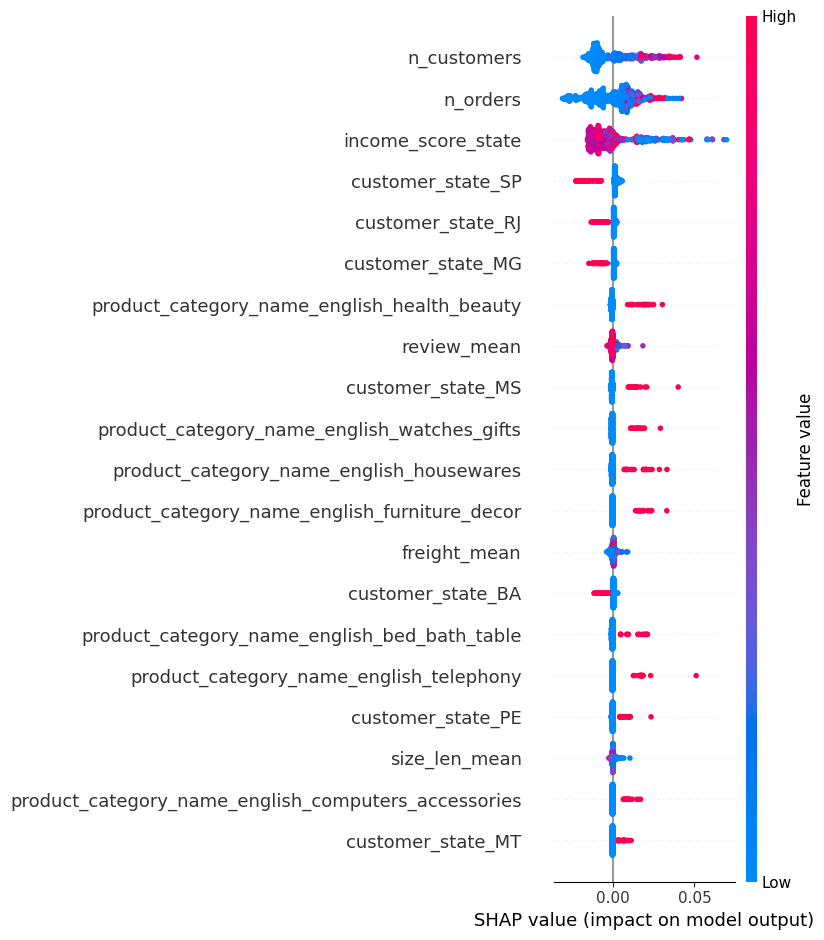

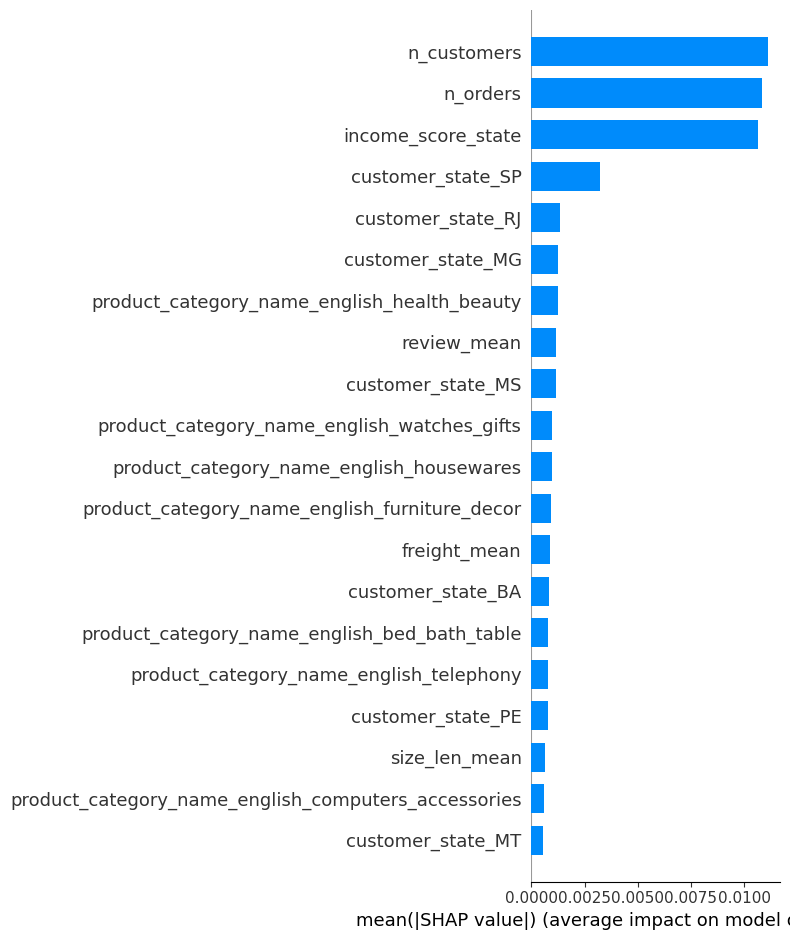

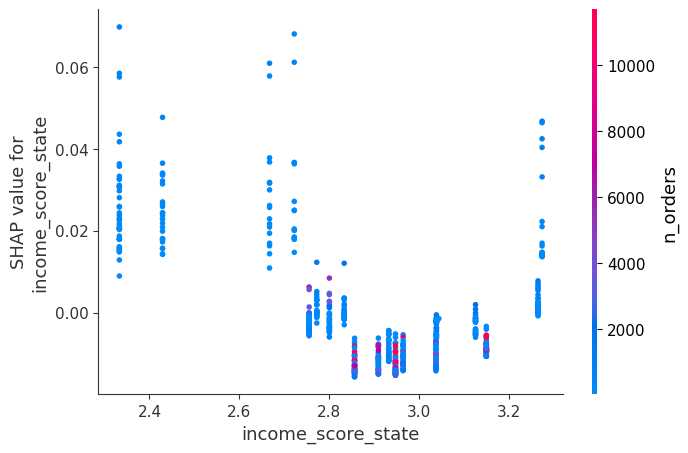

In [100]:
# Step 5) SHAP 해석
# pip install shap  (한 번만)
import shap
import matplotlib.pyplot as plt

explainer = shap.TreeExplainer(xgb_final)
shap_values = explainer.shap_values(X_enc)

# 5-1) 전역 중요도 (Summary Plot)
shap.summary_plot(shap_values, features=X_enc, feature_names=feat_names, show=True)

# 5-2) 상위 피처 바 차트
shap.summary_plot(shap_values, features=X_enc, feature_names=feat_names, plot_type="bar", show=True)

# 5-3) 특정 피처 의존도 (예: income_score_state)
shap.dependence_plot("income_score_state", shap_values, X_enc, feature_names=feat_names, show=True)


In [101]:
# Step 6) 예측값 붙이기 (원하면 주×카테고리 테이블에 y_hat 추가)
y_hat = xgb_final.predict(X_enc)
train_tbl["sales_rate_pred"] = y_hat
print(train_tbl[[STATE_COL, CAT_COL, "y", "sales_rate_pred"]].head())
# train_tbl.to_csv("train_tbl_with_pred.csv", index=False)


  customer_state product_category_name_english     y  sales_rate_pred
0             AL                          auto  0.00         0.000004
1             AL                          baby  0.01         0.009485
2             AL        books_general_interest  0.05         0.049314
3             AL         computers_accessories  0.15         0.150080
4             AL                consoles_games  0.00         0.000550


In [103]:
# sales_rate_pred = 주별 예측 판매율
import plotly.express as px

CATEGORY_TO_MAP = "bed_bath_table"  # 예시: 시각화하고 싶은 카테고리

map_df = (
    train_tbl.loc[train_tbl[CAT_COL] == CATEGORY_TO_MAP, [STATE_COL, "sales_rate_pred"]]
              .copy()
)
map_df["sales_rate_pred"] = map_df["sales_rate_pred"].clip(0, 1)

# 브라질 주(2글자) 코드와 연결되는 GeoJSON (click_that_hood)
GEOJSON_URL = "https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson"

fig = px.choropleth(
    map_df,
    geojson=GEOJSON_URL,
    locations=STATE_COL,                 # 예: "SP","RJ"...
    featureidkey="properties.sigla",     # geojson의 주 코드 키
    color="sales_rate_pred",
    color_continuous_scale="Viridis",
    range_color=(0, map_df["sales_rate_pred"].max()),
    scope="south america",
    title=f"Predicted Sales Rate by State — {CATEGORY_TO_MAP}"
)
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin=dict(l=0, r=0, t=50, b=0))
fig.show()


In [104]:
import plotly.express as px

topcat_by_state = (
    train_tbl
      .sort_values(["sales_rate_pred"], ascending=False)
      .groupby(STATE_COL, as_index=False)
      .first()[[STATE_COL, CAT_COL, "sales_rate_pred"]]
)

GEOJSON_URL = "https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson"

fig = px.choropleth(
    topcat_by_state,
    geojson=GEOJSON_URL,
    locations=STATE_COL,
    featureidkey="properties.sigla",
    color=CAT_COL,                  # 카테고리(범주형) 컬러링
    hover_data=["sales_rate_pred"],
    title="Top Predicted Category by State",
)
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin=dict(l=0, r=0, t=50, b=0))
fig.show()


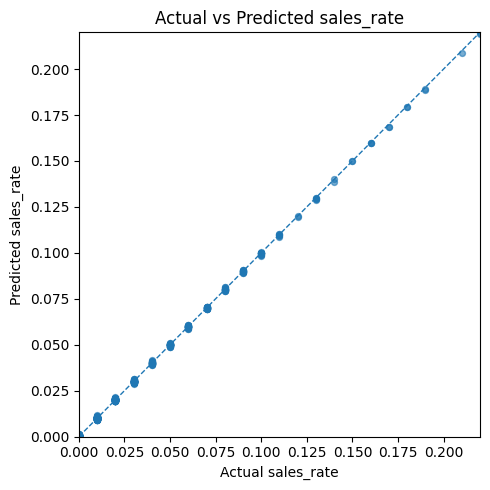

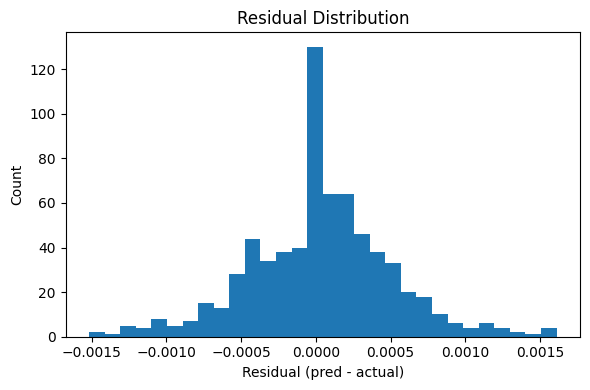

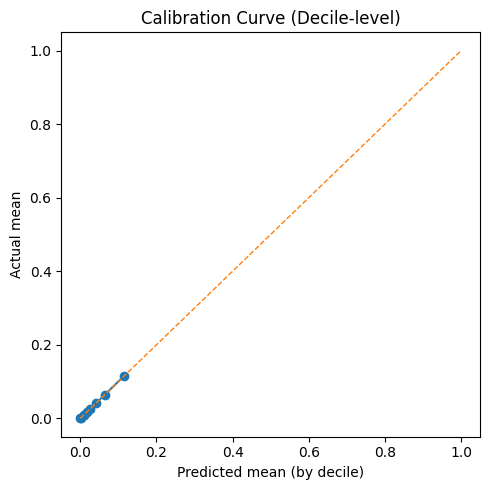

In [105]:
# (A) 기본 성능 플롯: 실제 vs 예측 산점도 + 잔차 분포 + 캘리브레이션(디사일)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 전제: train_tbl 에 [STATE_COL, CAT_COL, "y", "sales_rate_pred"] 존재
STATE_COL = "customer_state"
CAT_COL   = "product_category_name_english"

viz = train_tbl.copy()
viz["sales_rate_pred"] = viz["sales_rate_pred"].clip(0, 1)

y_true = viz["y"].values
y_pred = viz["sales_rate_pred"].values
resid  = y_pred - y_true

# 1) 실제 vs 예측 산점도
plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred, alpha=0.6, s=18)
lims = [0, max(0.001, y_true.max(), y_pred.max())]
plt.plot(lims, lims, "--", linewidth=1)
plt.xlim(lims); plt.ylim(lims)
plt.xlabel("Actual sales_rate")
plt.ylabel("Predicted sales_rate")
plt.title("Actual vs Predicted sales_rate")
plt.tight_layout()
plt.show()

# 2) 잔차 히스토그램
plt.figure(figsize=(6,4))
plt.hist(resid, bins=30)
plt.xlabel("Residual (pred - actual)")
plt.ylabel("Count")
plt.title("Residual Distribution")
plt.tight_layout()
plt.show()

# 3) 캘리브레이션(예측 디사일별 실제 평균)
viz["pred_decile"] = pd.qcut(viz["sales_rate_pred"], 10, labels=False, duplicates="drop")
calib = viz.groupby("pred_decile", as_index=False).agg(
    pred_mean=("sales_rate_pred", "mean"),
    actual_mean=("y", "mean"),
    n=("y","size")
)
plt.figure(figsize=(5,5))
plt.plot(calib["pred_mean"], calib["actual_mean"], marker="o")
plt.plot([0,1],[0,1], "--", linewidth=1)
plt.xlabel("Predicted mean (by decile)")
plt.ylabel("Actual mean")
plt.title("Calibration Curve (Decile-level)")
plt.tight_layout()
plt.show()


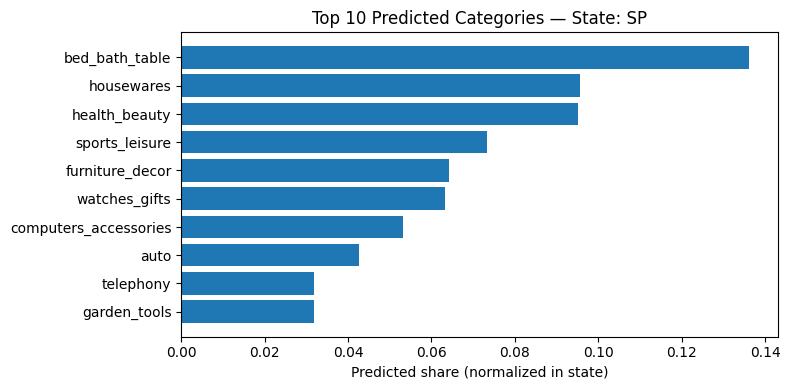

In [106]:
# (B) 주별 정규화된 예측 판매율로 상위 카테고리 막대 차트 (특정 주 선택)
import matplotlib.pyplot as plt

STATE_TO_SHOW = "SP"  # 원하는 주 코드로 변경

state_df = (
    train_tbl
      .loc[train_tbl[STATE_COL] == STATE_TO_SHOW, [CAT_COL, "sales_rate_pred"]]
      .copy()
)
state_df["sales_rate_pred"] = state_df["sales_rate_pred"].clip(0,1)

# 주 내 정규화(선택: 합=1로 맞추고 싶다면)
sum_pred = state_df["sales_rate_pred"].sum()
if sum_pred > 0:
    state_df["pred_norm"] = state_df["sales_rate_pred"] / sum_pred
else:
    state_df["pred_norm"] = state_df["sales_rate_pred"]

topk = state_df.sort_values("pred_norm", ascending=False).head(10)

plt.figure(figsize=(8,4))
plt.barh(topk[CAT_COL], topk["pred_norm"])
plt.gca().invert_yaxis()
plt.xlabel("Predicted share (normalized in state)")
plt.title(f"Top 10 Predicted Categories — State: {STATE_TO_SHOW}")
plt.tight_layout()
plt.show()


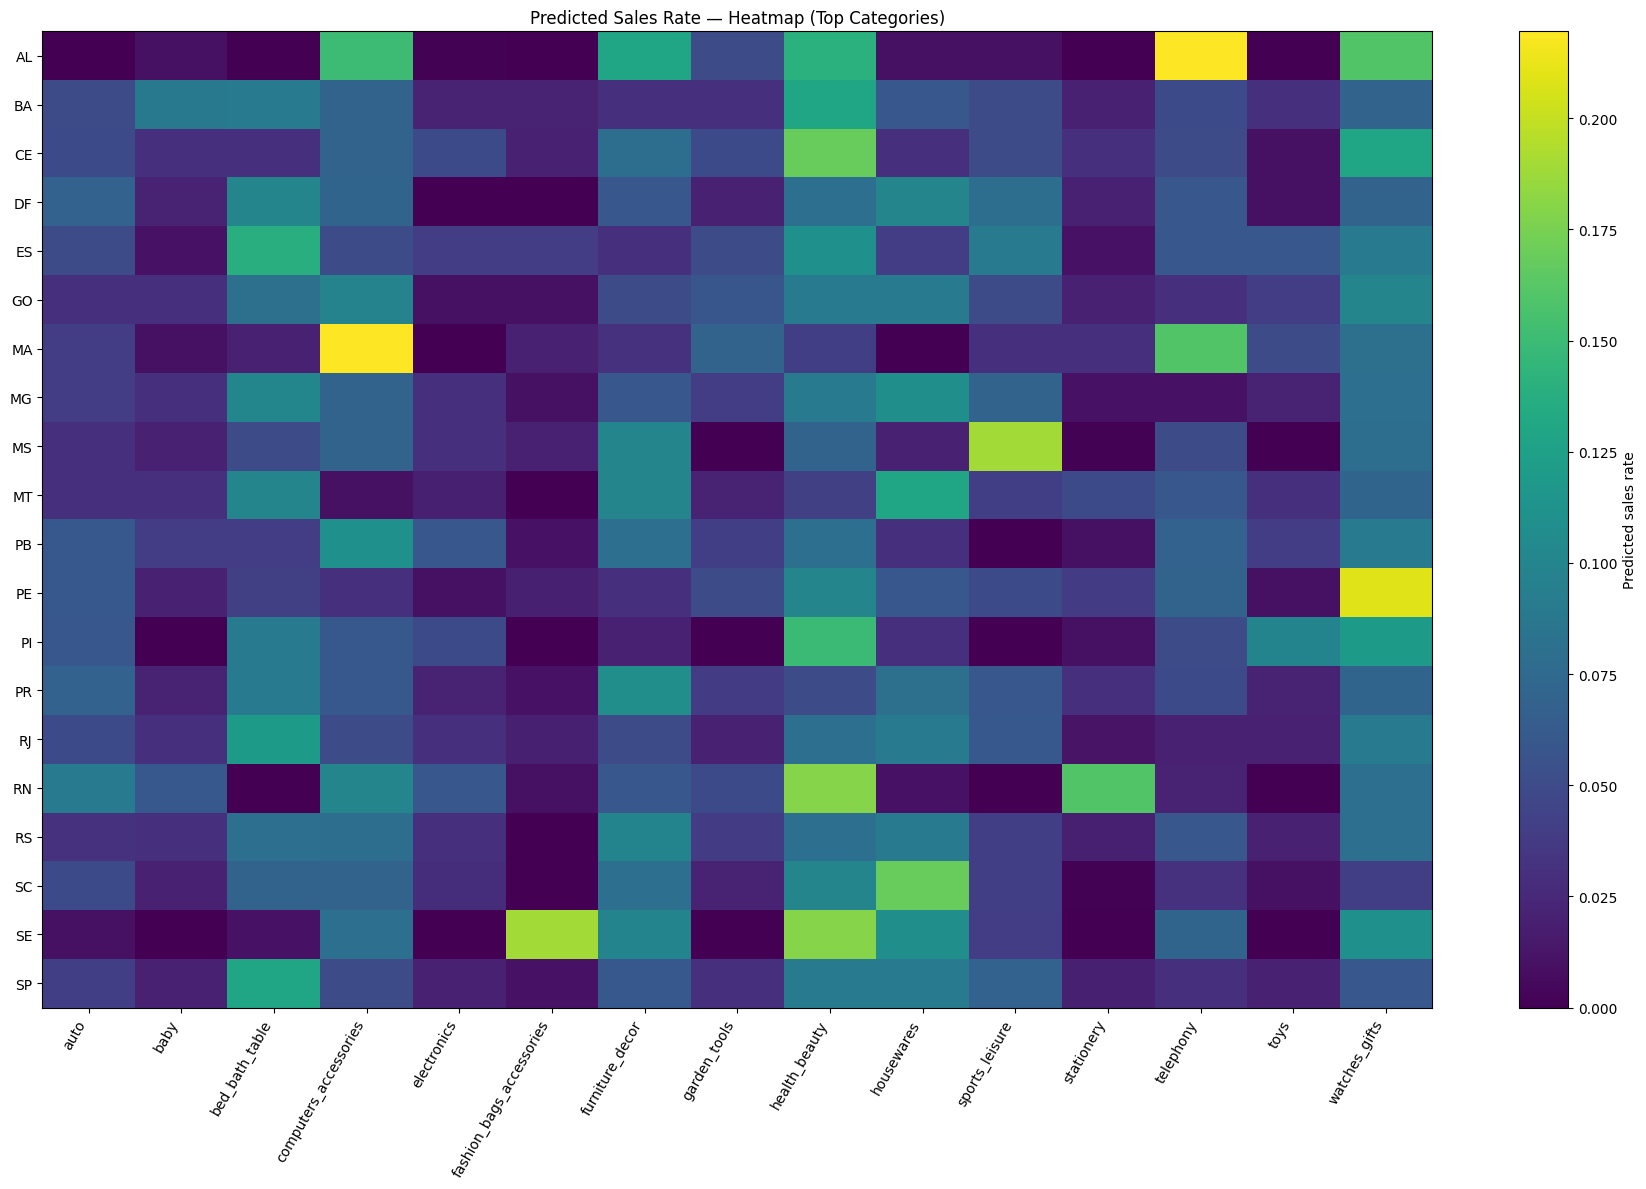

In [109]:
# (C) 주×카테고리 히트맵(피벗) — 예측 판매율 시각 요약
#  - 카테고리가 많으면 상위 N개만 표시 추천
import matplotlib.pyplot as plt

N_CAT = 15  # 상위 N개 카테고리 표시
top_cats = (
    train_tbl.groupby(CAT_COL)["sales_rate_pred"].sum()
             .sort_values(ascending=False).head(N_CAT).index
)
pvt = (
    train_tbl[train_tbl[CAT_COL].isin(top_cats)]
      .pivot(index=STATE_COL, columns=CAT_COL, values="sales_rate_pred")
      .fillna(0.0)
)

plt.figure(figsize=(1.2*len(top_cats), 0.5*len(pvt.index)+2))
# seaborn 없이 간단한 이미지 플롯
plt.imshow(pvt.values, aspect="auto")
plt.colorbar(label="Predicted sales rate")
plt.yticks(range(len(pvt.index)), pvt.index)
plt.xticks(range(len(pvt.columns)), pvt.columns, rotation=60, ha="right")
plt.title("Predicted Sales Rate — Heatmap (Top Categories)")
plt.tight_layout()
plt.show()


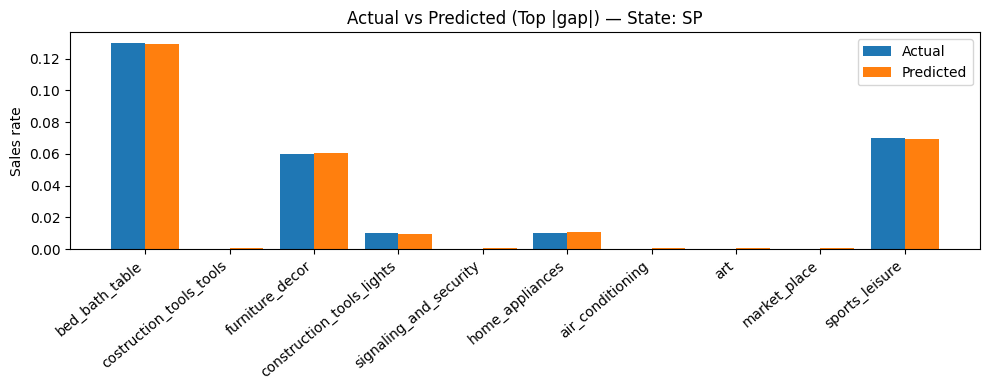

In [111]:
# (D) 실제 vs 예측 비교 바차트 — 특정 주에서 상위 카테고리
import matplotlib.pyplot as plt

STATE_TO_SHOW = "SP"  # 원하는 주로 변경

cmp = (
    train_tbl.loc[train_tbl[STATE_COL] == STATE_TO_SHOW, [CAT_COL, "y", "sales_rate_pred"]]
             .copy()
)
cmp["sales_rate_pred"] = cmp["sales_rate_pred"].clip(0,1)
cmp["gap"] = cmp["sales_rate_pred"] - cmp["y"]

top_abs_gap = cmp.reindex(cmp["gap"].abs().sort_values(ascending=False).head(10).index)

x = np.arange(len(top_abs_gap))
w = 0.4

plt.figure(figsize=(10,4))
plt.bar(x - w/2, top_abs_gap["y"], width=w, label="Actual")
plt.bar(x + w/2, top_abs_gap["sales_rate_pred"], width=w, label="Predicted")
plt.xticks(x, top_abs_gap[CAT_COL], rotation=40, ha="right")
plt.ylabel("Sales rate")
plt.title(f"Actual vs Predicted (Top |gap|) — State: {STATE_TO_SHOW}")
plt.legend()
plt.tight_layout()
plt.show()


In [113]:
# === Regression metrics + Confusion Matrices (binary & multiclass) ===
import numpy as np
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error,
    confusion_matrix, classification_report, root_mean_squared_error
)

# 1) 회귀 예측치
y_pred = xgb_final.predict(X_enc)
y_pred = np.clip(y_pred, 0.0, 1.0)   # 비율 타깃 가드

# 2) 회귀 성능 지표
rmse = root_mean_squared_error(y, y_pred)
mae  = mean_absolute_error(y, y_pred)
r2   = r2_score(y, y_pred)

print(f"[Regression] RMSE={rmse:.6f} | MAE={mae:.6f} | R^2={r2:.6f}")

# --------------------------------------------------------------------
# 3) Confusion Matrix (Binary): 판매율을 '높음/낮음'으로 이진화
#    - 기본: 실제값의 중앙값을 기준 임계값으로 사용 (원하면 사용자 정의로 변경)
# --------------------------------------------------------------------
THRESHOLD = float(np.median(y))  # 사용자 정의: 예) 0.05 등으로 교체 가능

y_true_bin = (y >= THRESHOLD).astype(int)
y_pred_bin = (y_pred >= THRESHOLD).astype(int)

cm_bin = confusion_matrix(y_true_bin, y_pred_bin, labels=[0, 1])
print("\n[Binary] Threshold =", THRESHOLD)
print("Confusion Matrix (rows=true, cols=pred) [labels: 0=Low, 1=High]:\n", cm_bin)
print("\nClassification report (binary):\n",
      classification_report(y_true_bin, y_pred_bin, target_names=["Low","High"], digits=4))

# --------------------------------------------------------------------
# 4) Confusion Matrix (Multiclass A–D): 사분위수 기준 4등급
#    - D (가장 낮음) ~ A (가장 높음)
# --------------------------------------------------------------------
q1, q2, q3 = np.quantile(y, [0.25, 0.5, 0.75])

def to_quartile_label(v):
    if v <= q1:      return "D"
    elif v <= q2:    return "C"
    elif v <= q3:    return "B"
    else:            return "A"

y_true_q = np.array([to_quartile_label(v) for v in y])
y_pred_q = np.array([to_quartile_label(v) for v in y_pred])

labels_q = ["A","B","C","D"]  # 보고 순서: 높은 등급 → 낮은 등급
cm_q = confusion_matrix(y_true_q, y_pred_q, labels=labels_q)

print("\n[Multiclass A–D] Quartile cut points:",
      f"Q1={q1:.6f}, Q2={q2:.6f}, Q3={q3:.6f}")
print("Confusion Matrix (rows=true, cols=pred) [labels: A,B,C,D]:\n", cm_q)
print("\nClassification report (A–D):\n",
      classification_report(y_true_q, y_pred_q, labels=labels_q, digits=4))

[Regression] RMSE=0.000476 | MAE=0.000348 | R^2=0.999836

[Binary] Threshold = 0.01
Confusion Matrix (rows=true, cols=pred) [labels: 0=Low, 1=High]:
 [[214   2]
 [ 80 398]]

Classification report (binary):
               precision    recall  f1-score   support

         Low     0.7279    0.9907    0.8392       216
        High     0.9950    0.8326    0.9066       478

    accuracy                         0.8818       694
   macro avg     0.8614    0.9117    0.8729       694
weighted avg     0.9119    0.8818    0.8856       694


[Multiclass A–D] Quartile cut points: Q1=0.000000, Q2=0.010000, Q3=0.040000
Confusion Matrix (rows=true, cols=pred) [labels: A,B,C,D]:
 [[164   1   0   0]
 [ 13 148   3   0]
 [  0  74  77   0]
 [  0   0 138  76]]

Classification report (A–D):
               precision    recall  f1-score   support

           A     0.9266    0.9939    0.9591       165
           B     0.6637    0.9024    0.7649       164
           C     0.3532    0.5099    0.4173       151
    

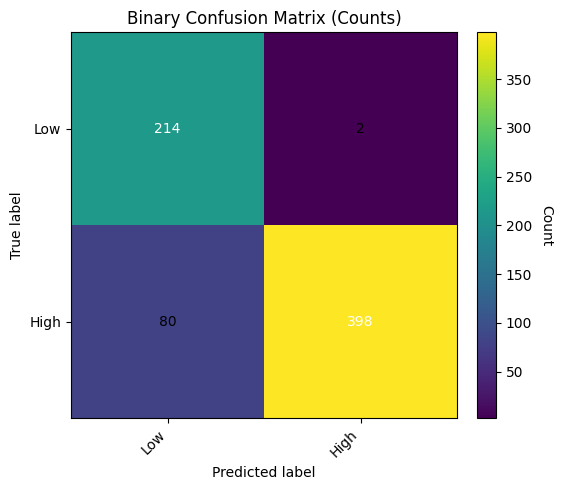

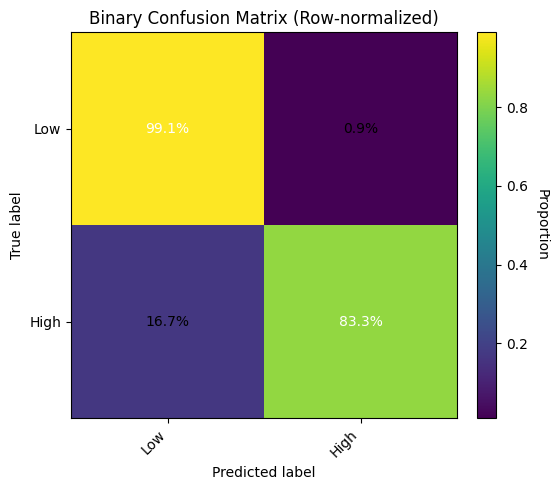

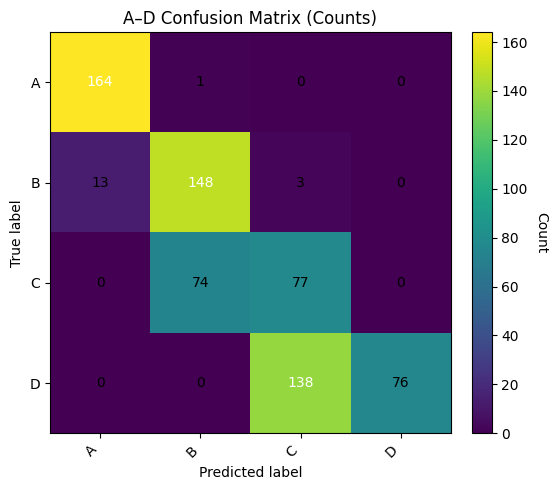

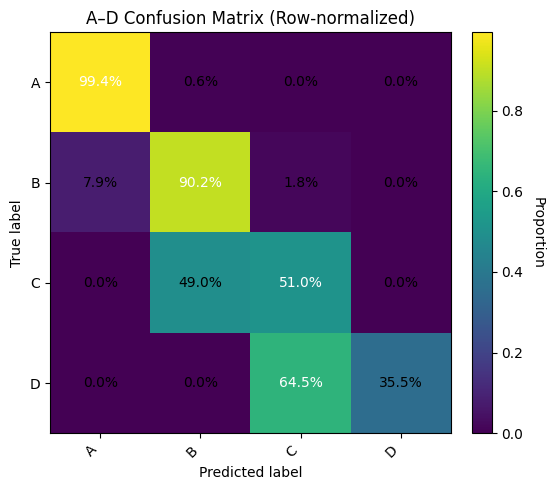

In [115]:
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, labels, title="Confusion Matrix", normalize=None):
    """
    cm: 2D numpy array (from sklearn.metrics.confusion_matrix)
    labels: list of class labels (order must match cm)
    normalize: None | 'true' | 'pred' | 'all'
      - None  : raw counts
      - 'true': row-normalized (recall)
      - 'pred': column-normalized (precision)
      - 'all' : overall percentage
    """
    cm = cm.astype(float)
    disp = cm.copy()

    if normalize == 'true':
        row_sums = cm.sum(axis=1, keepdims=True)
        disp = np.divide(cm, np.where(row_sums == 0, 1, row_sums))
    elif normalize == 'pred':
        col_sums = cm.sum(axis=0, keepdims=True)
        disp = np.divide(cm, np.where(col_sums == 0, 1, col_sums))
    elif normalize == 'all':
        total = cm.sum()
        disp = cm / (total if total != 0 else 1)

    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(disp)

    ax.set_title(title)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticklabels(labels)

    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel("Proportion" if normalize else "Count", rotation=270, labelpad=15)

    # annotate
    thresh = disp.max() / 2.0 if disp.size else 0.5
    for i in range(disp.shape[0]):
        for j in range(disp.shape[1]):
            txt = f"{disp[i, j]:.1%}" if normalize else f"{int(cm[i, j])}"
            ax.text(j, i, txt, ha="center", va="center",
                    color="white" if disp[i, j] > thresh else "black")

    ax.set_ylim(disp.shape[0]-0.5, -0.5)
    plt.tight_layout()
    plt.show()


# -----------------------------
# 사용 예시 (위에서 만든 cm_bin, cm_q 재사용)
# -----------------------------

# Binary CM
labels_bin = ["Low", "High"]
plot_confusion_matrix(cm_bin, labels_bin, title="Binary Confusion Matrix (Counts)", normalize=None)
plot_confusion_matrix(cm_bin, labels_bin, title="Binary Confusion Matrix (Row-normalized)", normalize="true")

# Multiclass A–D CM
labels_ad = ["A", "B", "C", "D"]
plot_confusion_matrix(cm_q, labels_ad, title="A–D Confusion Matrix (Counts)", normalize=None)
plot_confusion_matrix(cm_q, labels_ad, title="A–D Confusion Matrix (Row-normalized)", normalize="true")


클래스별 지표 해석 📊
Precision (정밀도): 모델이 특정 클래스로 예측한 샘플 중 실제 정답인 비율을 나타냅니다.

* A (0.9266): 'A'로 예측한 샘플 중 92.66%가 실제로 'A'였습니다.

* D (1.0000): 'D'로 예측한 모든 샘플이 실제로 'D'였습니다. 즉, 'D'로 잘못 예측한 경우가 없었습니다.

* C (0.3532): 'C'로 예측한 샘플 중 35.32%만이 실제 'C'였습니다. 'C'로 예측한 것 중 오답이 많았다는 의미입니다.

Recall (재현율): 실제 특정 클래스에 속하는 샘플 중 모델이 올바르게 예측한 비율을 나타냅니다.

* A (0.9939): 실제 'A'인 모든 샘플 중 99.39%를 모델이 'A'로 정확히 찾아냈습니다.

* D (0.3551): 실제 'D'인 샘플 중 35.51%만 'D'로 올바르게 예측했습니다. 실제 'D'인 샘플을 'D'가 아닌 다른 클래스로 잘못 예측한 경우가 많았다는 의미입니다.

F1-score: 정밀도와 재현율의 조화 평균으로, 두 지표가 모두 높아야 높은 값을 가집니다. 모델의 균형적인 성능을 평가하는 데 유용합니다.

* A (0.9591): 정밀도와 재현율이 모두 높아 F1-score가 매우 높습니다.

* D (0.5241): 정밀도는 높지만 재현율이 낮아 F1-score가 상대적으로 낮습니다.

Support (지원): 각 클래스의 실제 샘플 수입니다.

* 리포트 내 총 694개의 샘플 중 'A' 클래스는 165개, 'B'는 164개, 'C'는 151개, 'D'는 214개였습니다.

종합 지표 해석 📊
* Accuracy (정확도): 전체 샘플 중 모델이 올바르게 예측한 비율입니다. 이 모델은 전체 샘플의 67%를 올바르게 분류했습니다.

* Macro Avg (매크로 평균): 각 클래스 지표의 단순 평균입니다. 각 클래스의 중요도가 동일하다고 가정할 때 사용합니다.

* Weighted Avg (가중 평균): 각 클래스의 샘플 수(support)를 가중치로 사용하여 평균을 낸 값입니다. 샘플 수가 많은 클래스의 성능이 전체 평균에 더 큰 영향을 미칩니다.

결론 📝
* 이 모델은 'A' 클래스에 대해서는 매우 좋은 성능을 보이지만, 'C'와 'D' 클래스에 대해서는 성능이 떨어집니다.
* 특히, 'D' 클래스는 **정밀도(Precision)는 100%**로 매우 높지만 **재현율(Recall)은 35.51%**로 매우 낮습니다.
* 이는 모델이 'D'라고 예측하면 거의 정확하지만, 실제 'D'인 샘플을 제대로 찾아내지 못하는 문제가 있다는 것을 의미합니다. 반대로 'C' 클래스는 정밀도와 재현율이 모두 낮아 전반적인 성능이 좋지 않음을 보여줍니다.